# **Dataset 4 - Coronavirus tweets NLP - Text Classification**

**Description**
The "Coronavirus Tweets NLP - Text Classification" dataset contains thousands of tweets during the COVID-19 pandemic. Each tweet is annotated with one of five sentiment labels: extremely positive, positive, neutral, negative, or extremely negative. The dataset includes the text of each tweet, the user's location, and the date it was posted, enabling detailed analysis of public sentiment and trends during the early phase of the pandemic.

**Source**
https://www.kaggle.com/datasets/datatattle/covid-19-nlp-text-classification

**Machine Learning Task**
Multi-class Classification

**Motivation**
Twitter posts provide a great source of text data, as they reflect opinions from users worldwide. This dataset focuses on tweets about the coronoavirus during a time of reduced social interaction. Analyzing sentiments during this period offers insights into how the pandemic affected public opinions, especially regarding negative sentiments.

**Objective**
Develop a model to classify the sentiment expressed in tweets, aiding in sentiment analysis, trend detection, and public opinion monitoring during health crises.

The two machine learning models that will be used in this classification are Logistic Regression and Random Forest Classifier.

In [107]:
# # optional code cell when using Google Colab with Google Drive
# # mount Google Drive in Google Colab
# from google.colab import drive
# drive.mount('/content/drive')

# # change directory using the magic command %cd
# ### replace [MY PATH] below with your own path in Google Drive ###
# %cd /content/drive/My\ Drive/Fall 2024/ECE443/Term Project/Coronavirus Tweets NLP - Text Classification

In [108]:
# Imports
import numpy as np
import pandas as pd
from scipy import stats as sps
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from IPython.display import display, Latex
from wordcloud import WordCloud
import seaborn as sns
import nltk
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import defaultdict, Counter
import re
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, classification_report
from numpy import count_nonzero
import time

# Brief Exploration of the Dataset

In this section, Exploratory Data Analysis (EDA) is performed on the dataset to gain insight into the context, dimensionality, and common patterns in the data that will be handled and noted for pre-processing and future work.

In [109]:
# Read the train data CSV file into a dataframe
train_df = pd.read_csv('Corona_NLP_train.csv', encoding='Latin-1')

# Read the test data CSV file into a dataframe - NOTE: test set shall only be used for evaluations of models, but will have same processing applied to it (NO DATA LEAKAGE)
test_df = pd.read_csv('Corona_NLP_test.csv', encoding='Latin-1')

# Display all columns
print("Columns:")
display(train_df.columns)

# Display dtypes
print("\nData Types:")
display(train_df.dtypes)

# Display the first 10 rows of the train dataset
print("\nFirst 10 rows:")
train_df.head()

Columns:


Index(['UserName', 'ScreenName', 'Location', 'TweetAt', 'OriginalTweet',
       'Sentiment'],
      dtype='object')


Data Types:


UserName          int64
ScreenName        int64
Location         object
TweetAt          object
OriginalTweet    object
Sentiment        object
dtype: object


First 10 rows:


,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive
3,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,Positive
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative


There are six columns in the dataset: UserName (identifier, name), ScreenName (identifier, screen name), Location (where the Tweet originated from), TweetAt (the date the tweet was posted), OriginalTweet (the raw twitter text), and Sentiment (the label). There are *3 raw features*: Location, TweetAt, and OriginalTweet. There are *3 categorical variables*: Location, TweetAt, and Sentiment. There is currently *1 text data variable*: OriginalTweet. The output target variable is Sentiment.

The UserName and ScreenName columns are simply identifiers and are not considered as part of the feature or target variables.

In [110]:
# Get the number of samples
num_samples = len(train_df)
print(f"Number of samples: {num_samples}")

# Get the fraction of missing values
missing_values = train_df.isnull().sum() / num_samples
print(f"\nFraction of missing values: \n{missing_values}")

# Get the number of unique values in each column
unique_values = train_df.nunique()
print(f"\nNumber of unique values: \n{unique_values}")

# Get the number of (if any) duplicate samples
duplicate_samples = train_df.duplicated().sum()
print(f"\nNumber of duplicate samples: {duplicate_samples}")

Number of samples: 41157

Fraction of missing values: 
UserName         0.000000
ScreenName       0.000000
Location         0.208713
TweetAt          0.000000
OriginalTweet    0.000000
Sentiment        0.000000
dtype: float64

Number of unique values: 
UserName         41157
ScreenName       41157
Location         12220
TweetAt             30
OriginalTweet    41157
Sentiment            5
dtype: int64

Number of duplicate samples: 0


There are 41,157 data samples in the training dataset. Only the Location column has missing values (roughly 20.9% of the column has missing values). Based on the analysis of the number of unique values in each column, the UserName, ScreenName, and OriginalTweet columns have distinct values. The Location, TweetAt, and Sentiment columns have non-unique values.

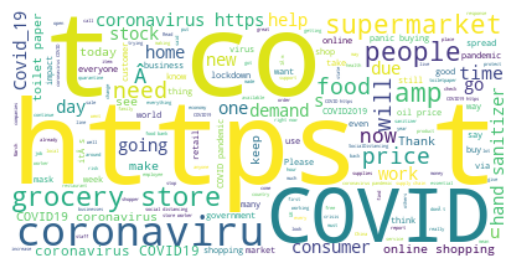

In [111]:
# Generate a word cloud to analyze the frequency of words that appear in the Tweets
tweet_text = train_df['OriginalTweet'].str.cat(sep=' ')
wordcloud = WordCloud(
    background_color='white'
).generate(tweet_text)

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

As shown in the WordCloud, some of the most common words used in the Tweets include irrelevant words such as "https", "amp", "t", "co", etc. which are associated with links and other text that has no true bearing on the sentiment or expressions behind the text. Nonetheless, as expected, some more useful common words do surface, such as "COVID" (as expected), "supermarket", "price", "food", etc. which may influence the sentiment of the text.

Another common suspicion is that the length of the Tweet has correlation with the sentiment of the Tweet. In the exercise below, the training data is filtered for Tweets of length 10 or shorter.

In [143]:
# Get only Tweets with 20 characters or less
display(train_df[train_df['OriginalTweet'].str.len() <= 20].head(10))

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment,TweetLength,SentimentEncoding
5709,9508,54460,Kashmir ?,19-03-2020,brings to its knees,Neutral,19,0
9167,12966,57918,"Aberdare, South Wales",20-03-2020,Meanwhile at home,Neutral,19,0
9776,13575,58527,"Scotland, United Kingdom",20-03-2020,Be like Bob,Positive,11,3
12047,15846,60798,"Cheras, Selangor",21-03-2020,only in France,Neutral,14,0
12399,16198,61150,NaN,21-03-2020,Seems about right,Neutral,18,0
12410,16209,61161,NaN,21-03-2020,This is why we 19,Neutral,17,0
12716,16515,61467,"London, England",21-03-2020,Stay safe everyone,Positive,18,3
15577,19376,64328,NaN,22-03-2020,Tissue Issue,Neutral,12,0
16872,20671,65623,?? ?,23-03-2020,Cartoon for,Neutral,11,0
16907,20706,65658,"New Delhi, India",23-03-2020,New York Don t Panic,Negative,20,1


Observe that an overhwelming majority of these very short (20 characters or less) Tweets have a Neutral sentiment. It is reasonable to further explore this and see if there is indeed a correlation between Tweet length and sentiment as shown in the following cell.

C:\Users\mogil\AppData\Local\Temp\ipykernel_46524\2378977781.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=train_df, x='Sentiment', y='TweetLength', palette='Set2')


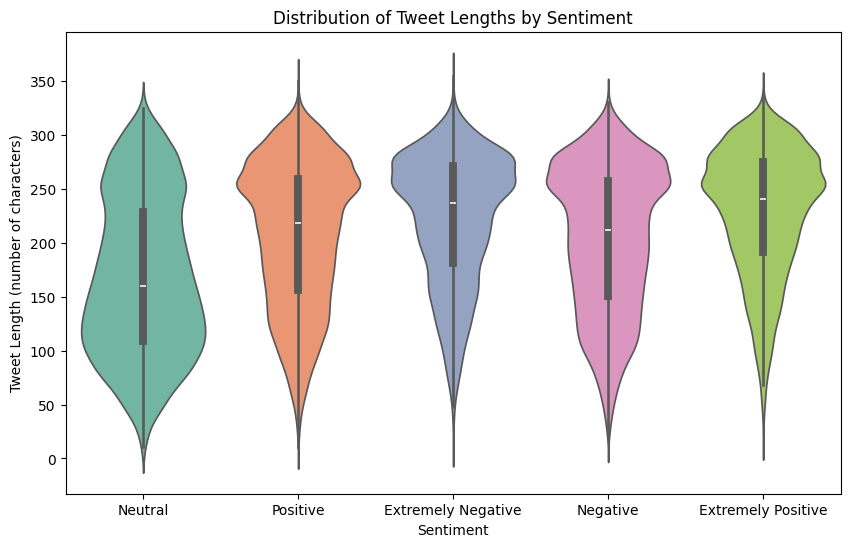

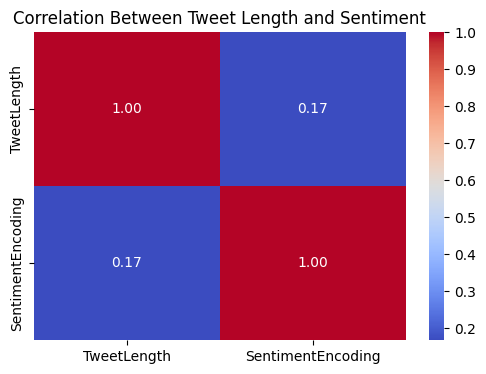

In [157]:
# Get TweetLength feature to see any correlations
train_df['TweetLength'] = train_df['OriginalTweet'].str.len()

# Distribution of Tweet lengths by sentiment
plt.figure(figsize=(10, 6))
sns.violinplot(data=train_df, x='Sentiment', y='TweetLength', palette='Set2')
plt.title('Distribution of Tweet Lengths by Sentiment')
plt.xlabel('Sentiment')
plt.ylabel('Tweet Length (number of characters)')
plt.show()

# Correlation heatmap between sentiment and Tweet length
train_df['SentimentEncoding'] = train_df['Sentiment'].map({ # temporary mapping to apply correlations
    'Extremely Negative': 0,
    'Negative': 1,
    'Neutral': 0,
    'Positive': 3,
    'Extremely Positive': 4
})
corr_matrix = train_df[['TweetLength', 'SentimentEncoding']].corr()
plt.figure(figsize=(6, 4))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title("Correlation Between Tweet Length and Sentiment")

# Drop the columns since they were simply used for EDA and most likely won't be needed in the future
train_df = train_df.drop(columns=['TweetLength', 'SentimentEncoding'])

There does seem to be somewhat of a significant correlation or difference between the number of characters in a Tweet and the sentiment category for that Tweet. In fact, the plots above demonstrate that there is indeed variance in character lengths among Tweets of different sentiments. Intuitively, this is reasonable; a shorter Tweet, unless using very extreme words, most likely can not express any true sentiment, so it won't be of an extreme sentiment. Longer Tweets have much more flexibility in expressing sentiment and can range and vary in sentiment. This is supported by the violin plot; the neutral sentiment Tweets generally have much shorter character lengths, and the extremely negative and positive sentiment Tweets have on average more characters than the negative and positive sentiment Tweets. This is something to take note of down the road.

The Tweet length is explored one more time in the following exercise, exploring the distribution of Tweet lengths across the Tweets.

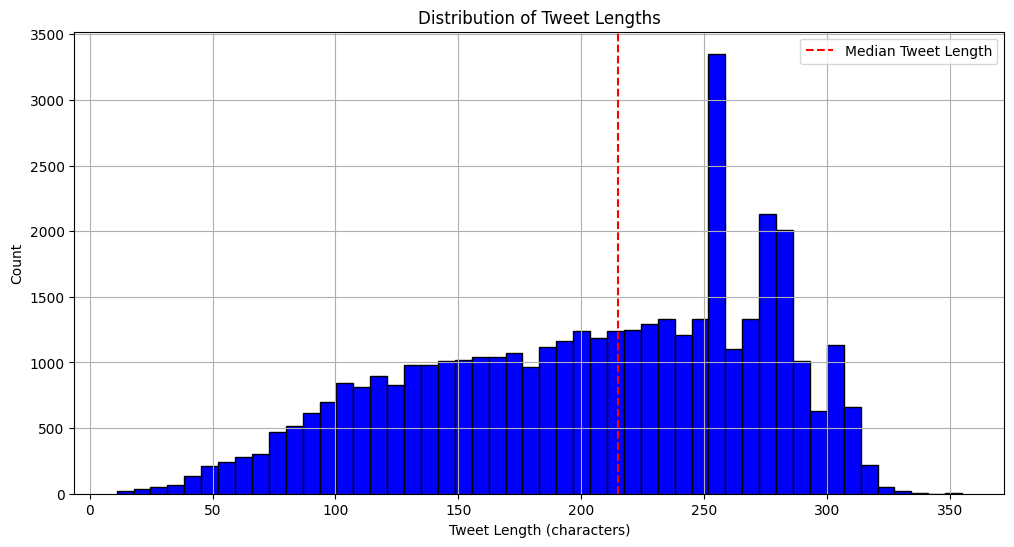

In [153]:
# Create histogram of the length of each tweet (number of characters)
tweet_len = train_df['OriginalTweet'].str.len()
plt.figure(figsize=(12, 6))
plt.hist(tweet_len, bins=50, color='blue', edgecolor='black')
plt.axvline(x=tweet_len.median(), color='red', linestyle='--', label='Median Tweet Length')
plt.xlabel('Tweet Length (characters)')
plt.ylabel('Count')
plt.title('Distribution of Tweet Lengths')
plt.legend()
plt.grid()
plt.show()

As shown, the raw tweet lengths (in terms of number of characters in the text) are left-skewed, with the mode tweet length around 250 to 275 characters. Very few tweets are beyond 325 characters in length.

Next, the distribution of the number of words in a tweet can also be explored.

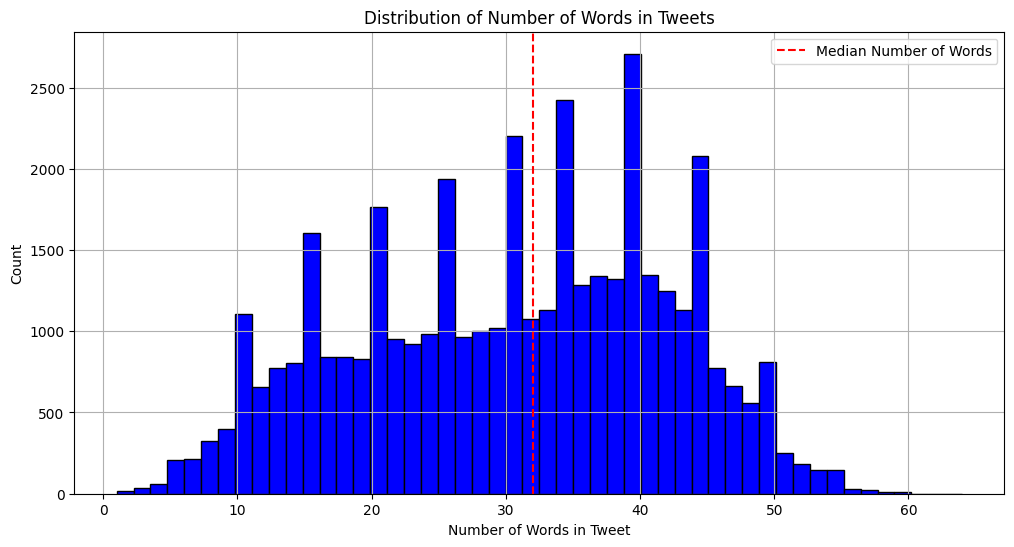

In [183]:
# Create a histogram of the number of words in each tweet
num_words = train_df['OriginalTweet'].str.split().map(len)
plt.figure(figsize=(12, 6))
plt.hist(num_words, bins=50, color='blue', edgecolor='black')
plt.axvline(x=num_words.median(), color='red', linestyle='--', label='Median Number of Words')
plt.xlabel('Number of Words in Tweet')
plt.ylabel('Count')
plt.title('Distribution of Number of Words in Tweets')
plt.legend()
plt.grid()
plt.show()

As shown, the distribution of the number of words in a Tweet is slightly left-skewed (with frequent peaks every 5 or so number of words in Tweets), with the median number of words in a Tweet hovering around 32 words.

Interestingly, this is in accordance with some further research on Twitter. For instance, Twitter only allows a Tweet length of 280 characters (free accounts) and 25000 characters (X Premium subscribers). This not only verifies the previous discovery about the distribution of Tweet lengths, but also verifies the above, since the 280 character limit most likely comes down to about 60 words or so, which is shown to be around the maximum number of words in a Tweet observed (this includes hashtags, emojis, etc.). Also, observe how there are more Tweets with less words than Tweets with more words.

However, this does not directly imply that the Tweets only use very short words. For instance, the Tweets may contain stopwords, which are words most commonly used in the language ("the", "a", etc.). This is most likely causing the skew displayed in the distribution of average word lengths, so it is important to analyze how many and the types of stopwords there are in the Tweet text to gain more insight into the data.

The nltk library provides a corpus of stopwords from various languages; given the data exploration, however, the texts are in English, and so the English stopwords will be extracted from the corpus in the following exercise.

In [115]:
# Download nltk corpus and extract english stop words
nltk.download('stopwords')
stop_words = set(nltk.corpus.stopwords.words('english'))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\mogil\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


As shown, the extracted english stopwords from the nltk corpus are very common words in the English language, which are not as relevant towards the sentiment of the Tweets.

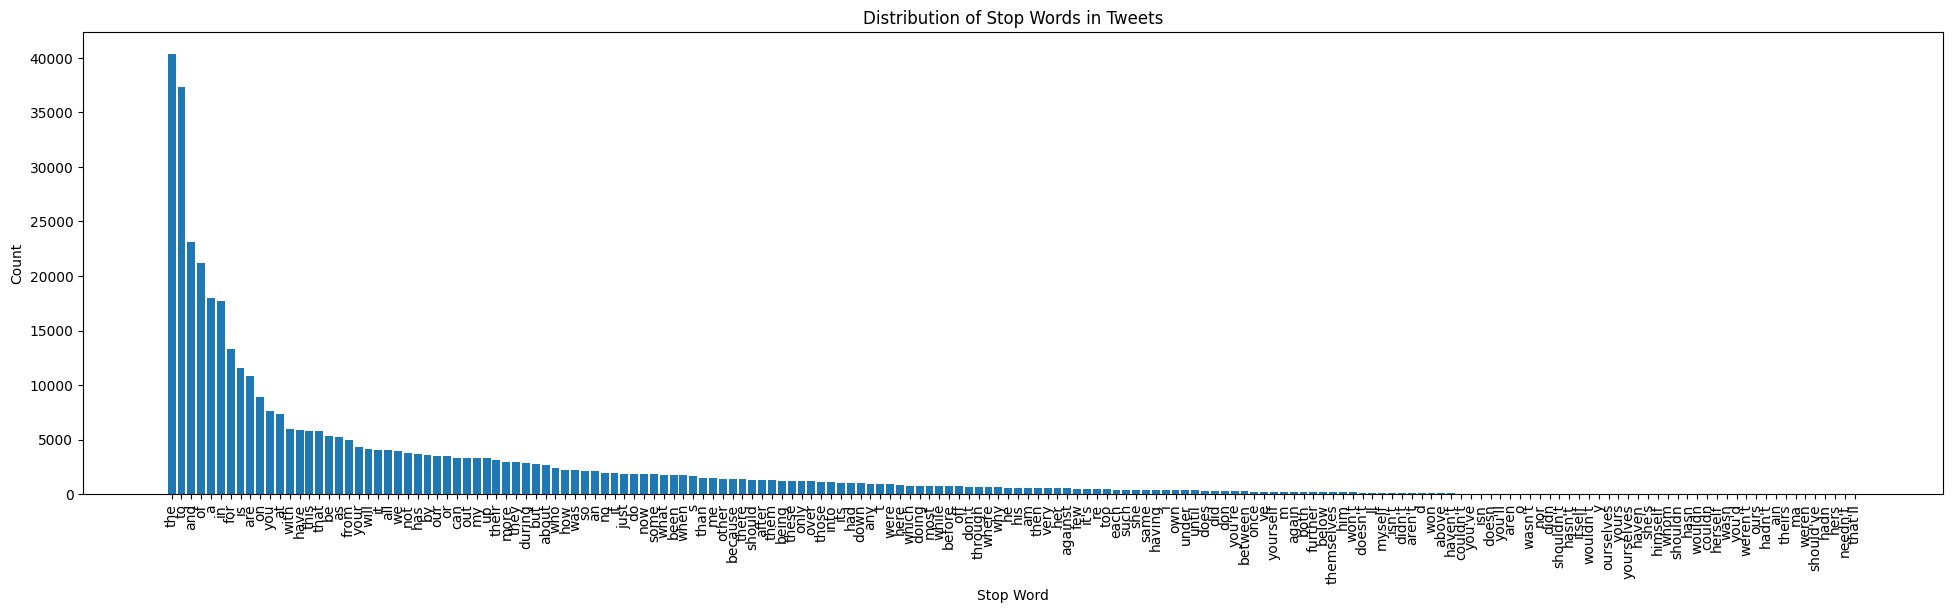

In [116]:
# Create corpus of all words from the Tweets
corpus = [word for tweet in train_df['OriginalTweet'].str.split().values.tolist() for word in tweet]

# Count how many times each stop word appears in the Tweets (using the corpus created above)
count_stop_words = defaultdict(int)
for word in corpus:
  if word in stop_words:
    count_stop_words[word] += 1

# Sort in decreasing frequency of stop words
count_stop_words = dict(sorted(count_stop_words.items(), key=lambda freq : freq[1], reverse=True))

# Plot the frequency of stop words in the Tweets
plt.figure(figsize=(24,6))
plt.bar(count_stop_words.keys(), count_stop_words.values())
plt.xlabel('Stop Word')
plt.ylabel('Count')
plt.title('Distribution of Stop Words in Tweets')
plt.xticks(rotation=90)
plt.show()

Thus, it is immediately evident that the Tweets collectively contain thousands of stop words, with the most common ones including "the", "to", "and", "of", "a", "in", "for", "is", "are", "on", "you", "at", etc.

The implications are that in the pre-processing of the data, in addition to words unrelated to sentiment such as "https", stopwords will also need to be filtered out to reduce the dimensionality of the numerical vectors representing the text data and reduce noise in the data when predicting sentiment. This is explored in greater detail in a future section.

Although the WordCloud provided a visualization of the top words in the Tweets, the actual count of the top 20 most common words in the Tweets can also be analyzed in the following exercise.

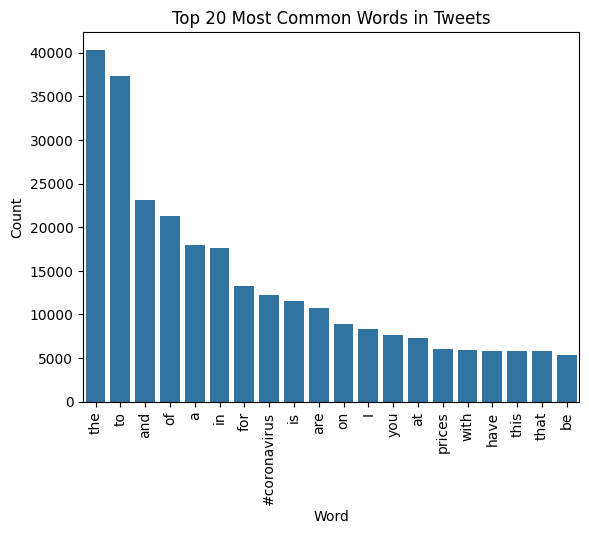

In [117]:
# Get the top 20 most common words in the Tweets
counter = Counter(corpus)
top_20_most_common_words = counter.most_common(20)

# Plot the top 20 most common words in the Tweets and their counts
word_list, count_list = zip(*top_20_most_common_words)
sns.barplot(x=word_list, y=count_list)
plt.xlabel('Word')
plt.ylabel('Count')
plt.title('Top 20 Most Common Words in Tweets')
plt.xticks(rotation=90)
plt.show()

Again, observe that so many of the most common words in the tweets are part of the stop words (compare with the distribution of stop words in the previous exercise). Stopwords like "the", "to", "and", etc. should be filtered from the Tweets' texts during the pre-processing stage.

Another exercise in exploring the text data involves exploring Ngrams, which are contiguous sequences of n words. For instance, N = 2 for "I am", N = 3 for "Who are you", etc. Exploring the most frequent Ngrams in the text data can provide insight into not just the words in the Tweets, but also their context windows. For the following exercise, Ngrams is implemented with the nltk.util module.

The Tweet text vocabulary is represented through the Countervectorizer method in sklearn.feature_engineering.text, which helps tokenize/vectorize and represent the corpus.

In [118]:
def get_top_Ngrams(corpus, n=1, top=10):
  """
  Retrieves the top Ngrams from the corpus.

  :param n: the top Ngrams to retrieve
  :param top: the number of top Ngrams to retrieve
  :return: a list of the top Ngrams based on decreasing frequency
  """
  vectorized = CountVectorizer(ngram_range=(n,n)).fit(corpus) # initialize a CountVectorizer that extracts n-grams of size n (e.g., for n=2, ["i like my phone"] = ["i like", "like my", "my phone"]) and fits the corpus to build vocab of n-grams
  bag_of_words = vectorized.transform(corpus) # convert corpus into sparse matrix bag of words, rows are documents and columns are counts of n-grams
  sum_of_words = bag_of_words.sum(axis=0) # collapse sparse matrix into one row, each column is total number of the n-gram for that corpus
  frequency_of_words = [(word, sum_of_words[0,index]) for word, index in vectorized.vocabulary_.items()] # the vocabulary_ is a dict mapping every n-gram to the sparse matrix index; this creates a list of tuples, each tuple is an n-gram with total count of it
  frequency_of_words = sorted(frequency_of_words, key=lambda x : x[1], reverse=True) # sort the n-grams by frequency
  return frequency_of_words[:top] # return the top n-grams

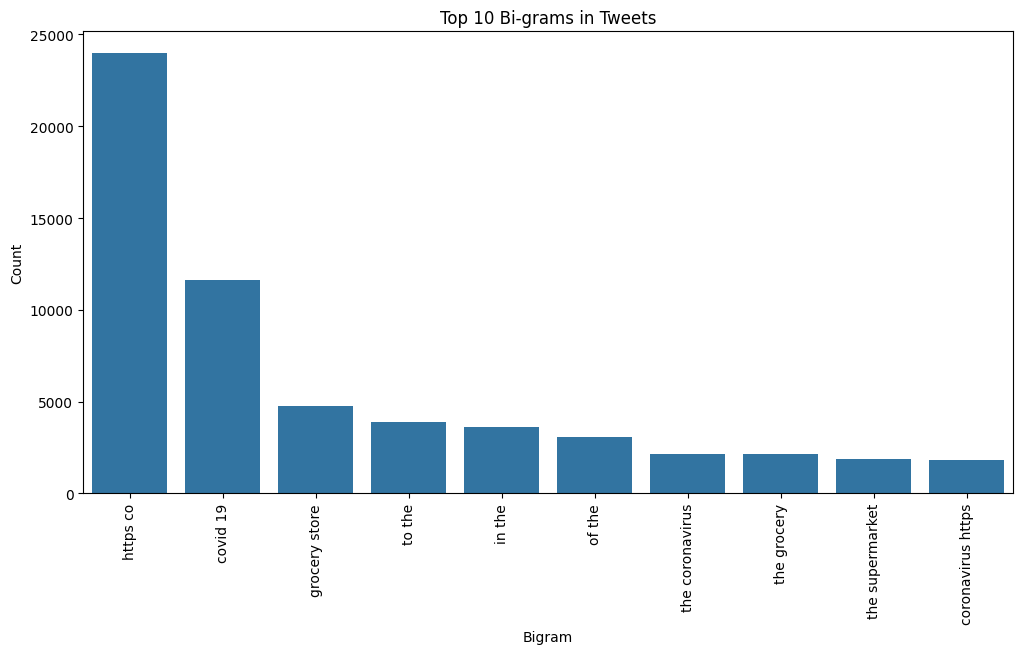

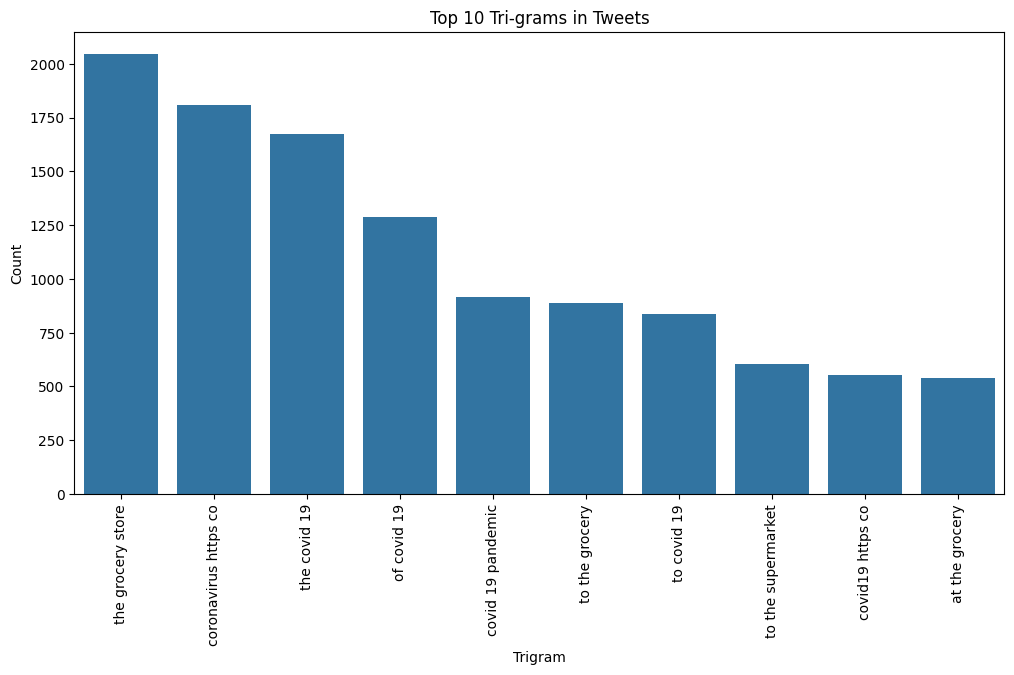

In [119]:
# Get the top 10 bi-grams from the Tweets
top_10_bigrams = get_top_Ngrams(train_df['OriginalTweet'], n=2, top=10)

# Plot the top 10 bi-grams from the Tweets
word_list, count_list = zip(*top_10_bigrams)
plt.figure(figsize=(12,6))
sns.barplot(x=word_list, y=count_list)
plt.xlabel('Bigram')
plt.ylabel('Count')
plt.title('Top 10 Bi-grams in Tweets')
plt.xticks(rotation=90)
plt.show()

# Get the top 10 tri-grams from the Tweets
top_10_bigrams = get_top_Ngrams(train_df['OriginalTweet'], n=3, top=10)

# Plot the top 10 tri-grams from the Tweets
word_list, count_list = zip(*top_10_bigrams)
plt.figure(figsize=(12,6))
sns.barplot(x=word_list, y=count_list)
plt.xlabel('Trigram')
plt.ylabel('Count')
plt.title('Top 10 Tri-grams in Tweets')
plt.xticks(rotation=90)
plt.show()

Based on the top 10 bi-grams and tri-grams from the Tweet text data, it seems like the "grocery" store and "supermarket" and "covid 19" are featured the most. Synonyms such as "grocery store" and "supermarket" can be combined into singular tokens during data cleaning and pre-processing. Also, it is again obvious that irrelevant words such as "https" and "co" appear in these Ngrams and will need to be filtered as well.

The distribution of target classes (the sentiment labels) can also be explored, as shown in the exercise below.

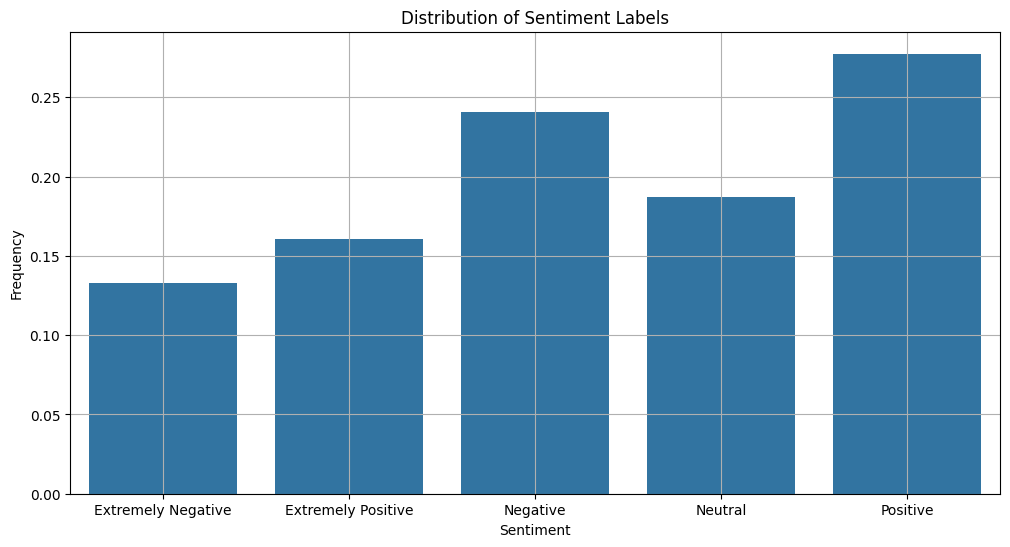

Sentiment
Extremely Negative    0.133173
Extremely Positive    0.160945
Negative              0.240955
Neutral               0.187404
Positive              0.277523
Name: Sentiment, dtype: float64

In [120]:
# Plot the frequency/empirical prior probability for each sentiment label class
sentiment_counts = train_df['Sentiment'].groupby(train_df['Sentiment']).count()
sentiment_frequencies = sentiment_counts / sentiment_counts.sum()

plt.figure(figsize=(12,6))
sns.barplot(x=sentiment_frequencies.index, y=sentiment_frequencies.values)
plt.xlabel('Sentiment')
plt.ylabel('Frequency')
plt.title('Distribution of Sentiment Labels')
plt.grid()
plt.show()

sentiment_frequencies

The distribution of sentiment labels is not really uniform. The "Positive" sentiment class is most frequent with an empirical prior probability of 0.277523, followed by the "Negative" sentiment class with an empirical prior probability of 0.240955, followed by the "Neutral" sentiment class with an empirical prior probability of 0.187404, follwed by the "Extremely Positive" sentiment class with an empirical prior probability of 0.160945, followed by the "Extremely Negative" sentiment class with the lowest empirical prior probability of 0.133173.

Another interesting aspect of the data may be not just the most common words in the Tweets, but rather the most common words for each sentiment label. This aligns more closely with the overall task of this project, which is sentiment analysis of the Tweet text. The exercise below explores the most common words for each sentiment.

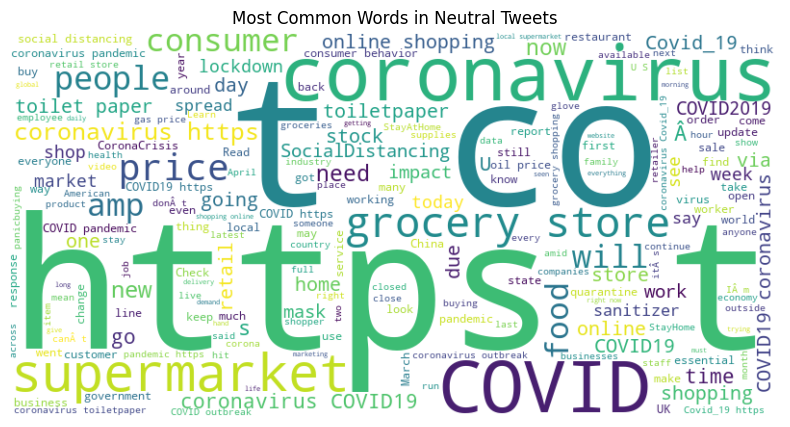

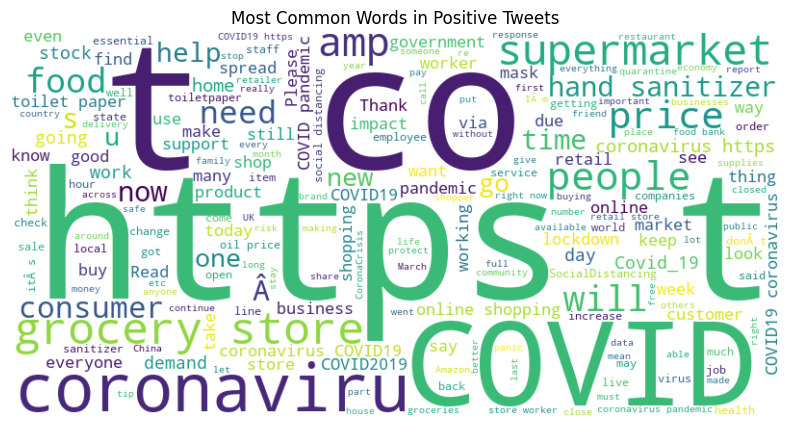

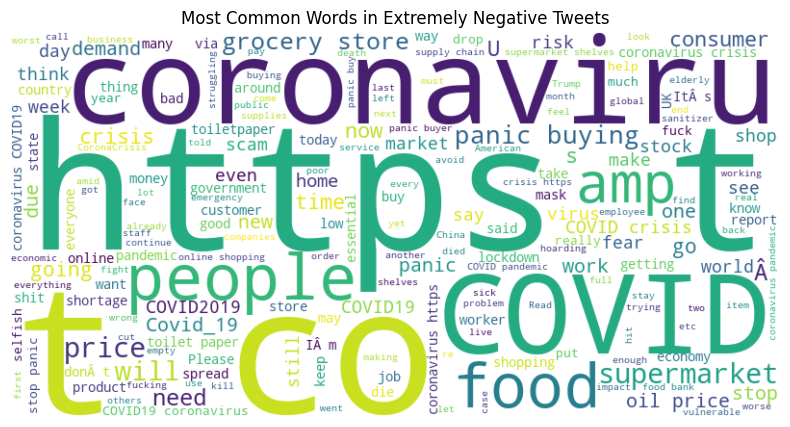

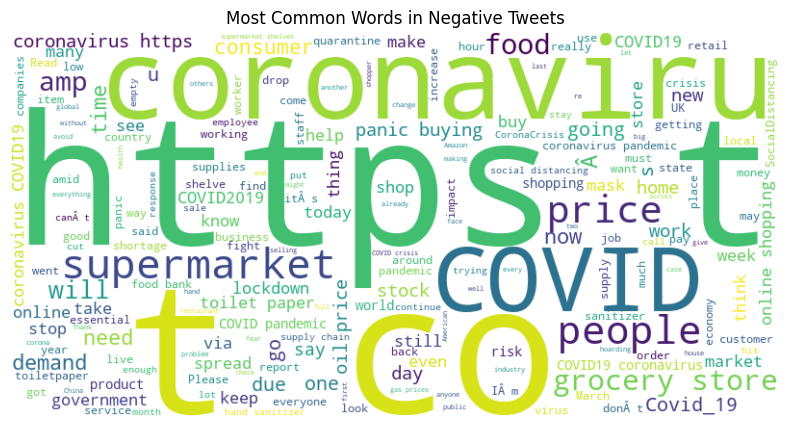

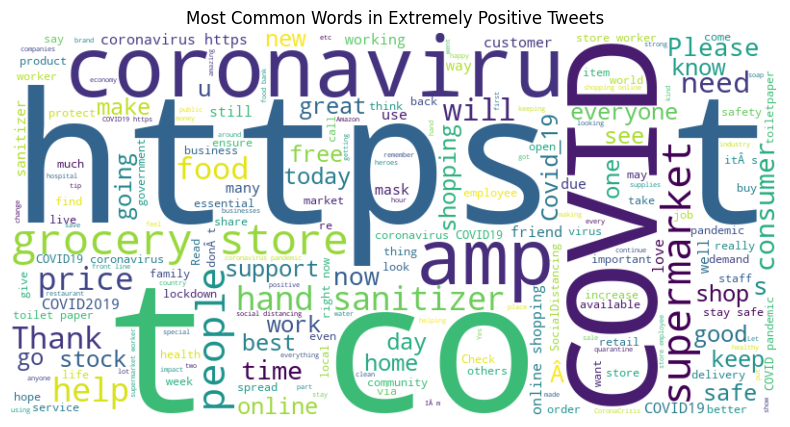

In [121]:
def create_wordcloud(sentiment):
    text = " ".join(train_df[train_df['Sentiment'] == sentiment]['OriginalTweet'].astype(str))
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f'Most Common Words in {sentiment} Tweets')
    plt.axis('off')
    plt.show()
    
for sentiment in train_df['Sentiment'].unique():
    create_wordcloud(sentiment)

Again, a lot of the stop words, links ("https"), etc. appear that give a false representation of the more important words in the Tweets of each sentiment, signifying how important it will be to clean and pre-process the text data. Nonetheless, some patterns are still noticeable. For instance, extremely positive Tweets seem to have words like "thank", "good", "keep", "safe", etc. which are all associated with positivity. In fact, apart from mentions of "COVID 19" and "coronavirus", there does not seem to be any significantly negative words at all. On the other extreme, extremely negative Tweets seem to have words like "price", "food", "fear", "panic", etc. which are intuitively extremely negative words. A similar argument can be made for the positive and negative Tweets. The interesting part here is the neutral Tweets; the words featured the most for neutral Tweets talk about "price", "grocery", "food", etc. which do not lean towards any particular side and are quite balanced. This does not really provide any surprising results, but is nonetheless useful for getting a sense of how these sentiment rankings work (reference the section on ethics at the end of this notebook).

Looking at samples of the actual Tweet texts associated with each sentiment might also reveal something useful, as shown in the following exercise.

In [160]:
# To display more of the text for analysis
pd.set_option('display.max_colwidth', None)

In [166]:
# Print the extremely positive Tweets
print(train_df.loc[train_df['Sentiment'] == 'Extremely Positive']['OriginalTweet'].head(15))

11                                                                           Due to the Covid-19 situation, we have increased demand for all food products. \r\r\n\r\r\nThe wait time may be longer for all online orders, particularly beef share and freezer packs. \r\r\n\r\r\nWe thank you for your patience during this time.
12                                         #horningsea is a caring community. LetÂs ALL look after the less capable in our village and ensure they stay healthy. Bringing shopping to their doors, help with online shopping and self isolation if you have symptoms or been exposed to somebody who has. https://t.co/lsGrXXhjhh
18                           Amazon Glitch Stymies Whole Foods, Fresh Grocery Deliveries\r\r\nÂAs COVID-19 has spread, weÂve seen a significant increase in people shopping online for groceries,Â a spokeswoman said in a statement. ÂToday this resulted in a systems impact affecting our ...\r\r\n https://t.co/TbzZ2MC3b3
22                  We have AMA

Above is a select sample of Tweets labeled as Extremely Positive. Interestingly, observe data samples for rows 22 and 23. They are nearly identical messages, with a different orientation of hashtags. It could be argued both ways for whether or not to remove such duplicates based on setting some maximum similarity allowed. However, it is still possible that the texts may align except for a very few select number of words, which might be extreme enough to skew the sentiment one way or another. Also, observe the data sample on row 48 ("Never tought...") or on row 58 ("With the outbreak of Covid-19..."); these don't sound extremely positive at all, raising questions over how these Tweets were labeled in terms of sentiment. It is possible that semi-supervised learning is a must for this dataset, where it is better to train on a select portion of data samples that have a sentimnt labeled.

In [167]:
# Print the positive Tweets
print(train_df.loc[train_df['Sentiment'] == 'Positive']['OriginalTweet'].head(15))

1                                                                                         advice Talk to your neighbours family to exchange phone numbers create contact list with phone numbers of neighbours schools employer chemist GP set up online shopping accounts if poss adequate supplies of regular meds but not over order
2                                                                                                                                                                                                   Coronavirus Australia: Woolworths to give elderly, disabled dedicated shopping hours amid COVID-19 outbreak https://t.co/bInCA9Vp8P
3     My food stock is not the only one which is empty...\r\r\n\r\r\nPLEASE, don't panic, THERE WILL BE ENOUGH FOOD FOR EVERYONE if you do not take more than you need. \r\r\nStay calm, stay safe.\r\r\n\r\r\n#COVID19france #COVID_19 #COVID19 #coronavirus #confinement #Confinementotal #ConfinementGeneral https://t.co/zrlG0Z520j
5               

Above is a select sample of Tweets labeled as Positive. Nothing too surprisingly or immediate obvious, but it can be noted that the final sample (row 47) uses extremely negative words like "dumb" and "idiots", and yet it was labeled at Positive; it's possible the "lol" at the end skews the sentiment to be positive as it's viewed as more humorous, but it still does raise further questions about how the sentiments were labeled.

In [168]:
# Print the neutral Tweets
print(train_df.loc[train_df['Sentiment'] == 'Neutral']['OriginalTweet'].head(15))

0                                                                                                                                                                          @MeNyrbie @Phil_Gahan @Chrisitv https://t.co/iFz9FAn2Pa and https://t.co/xX6ghGFzCC and https://t.co/I2NlzdxNo8
7                                                                                                                                                            Was at the supermarket today. Didn't buy toilet paper. #Rebel\r\r\n\r\r\n#toiletpapercrisis #covid_19 https://t.co/eVXkQLIdAZ
10    All month there hasn't been crowding in the supermarkets or restaurants, however reducing all the hours and closing the malls means everyone is now using the same entrance and dependent on a single supermarket. #manila #lockdown #covid2019 #Philippines https://t.co/HxWs9LAnF9
16                                                                   ????? ????? ????? ????? ??\r\r\n?????? ????? ??????? ????????? ?\r\r\n#????_???? ?

Above is a select sample of Tweets labeled as Neutral. Observe data samples such as the first one (row 0) or row 16. They are entirely made up of hashtags or some extraneous symbols. Thinking forward, if one was to clean the data to remove hashtags and other symbols and apply other pre-processing methods, these texts would become essentially empty or very short (five or less words). If anything, this would make it nearly impossible to actually predict the sentiment for such text because if it is full of symbols that will get parsed out, then what is there to analyze? This will be revisted during the training of the models to accomplish the sentiment analysis task.

In [169]:
# Print the extremely negative Tweets
print(train_df.loc[train_df['Sentiment'] == 'Negative']['OriginalTweet'].head(15))

9                                 For corona prevention,we should stop to buy things with the cash and should use online payment methods because corona can spread through the notes. Also we should prefer online shopping from our home. It's time to fight against COVID 19?. #govindia #IndiaFightsCorona
24                                            @10DowningStreet @grantshapps what is being done to ensure food and other essential products are being re-stocked at supermarkets and panic buying actively discouraged? It cannot be left to checkout staff to police the actions of the selfish and profiteer
26                                                                                                 In preparation for higher demand and a potential food shortage, The Hunger Coalition purchased 10 percent more food and implemented new protocols due to the COVID-19 coronavirus. https://t.co/5CecYtLnYn
28    Do you see malicious price increases in NYC? The NYC Department of Consumer and Worker P

Above is a select sample of Tweets labeled as Negative. Nothing is too surprising, but it can be noted that, for instance, observe row 26; for this data sample, it is very objective and simply stating a fact about new protocols being implemented. It could be argued this is Negative, or it leans toward Neutral. Again, reference the section on ethics in this notebook. It might be worthwhile to research how these Tweets in the dataset were labeled based on sentiment.

In [170]:
# Print the extremely negative Tweets
print(train_df.loc[train_df['Sentiment'] == 'Extremely Negative']['OriginalTweet'].head(15))

4      Me, ready to go at supermarket during the #COVID19 outbreak.\r\r\n\r\r\nNot because I'm paranoid, but because my food stock is litteraly empty. The #coronavirus is a serious thing, but please, don't panic. It causes shortage...\r\r\n\r\r\n#CoronavirusFrance #restezchezvous #StayAtHome #confinement https://t.co/usmuaLq72n
20                                                                            with 100  nations inficted with  covid  19  the world must  not  play fair with china  100 goverments must demand  china  adopts new guilde  lines on food safty  the  chinese  goverment  is guilty of  being  irosponcible   with life  on a global scale
27                                               This morning I tested positive for Covid 19. I feel ok, I have no symptoms so far but have been isolated since I found out about my possible exposure to the virus.  Stay home people and be pragmatic. I will keep you updated on how IÂm doing ???? No panic. https://t.co/Lg7HVMZglZ
29        

Above is a select sample of Tweets labeled as Extremely Negative. Observe that the Tweets are much longer which agrees with previous observations in EDA; they are more flexible and can express more extreme and varied sentiments with more words. Still, it's interesting that, for instance, on row 27, the data sample ends in "No panic" but is viewed as Extremely Negative.

Nonetheless, by skimming through the various samples of Tweets associated with different sentiments, it is clear that data cleaning and pre-processing is a must. Too many of the Tweet texts have hashtags, mentions, links, excessive random symbols and punctuation, special characters, numbers, dates/times, incorrect spelling, etc.

A lot of the EDA has been spent on deeply analyzing the various observable patterns in the Tweet text data and its correlations with the sentiment labels of the Tweets. However, recall that there were still the 'Location' and 'TweetAt' columns. Although the main objective of this task will ignore the location and date of Tweet for sentiment analysis, as they can introduce unwanted societal and other types of biases into the sentiment predictions, it is worthwhile to briefly explore their own correlations among the features to see how important or influential they are. First, the next cell looks at the top 5 locations of where the Tweets originated from.

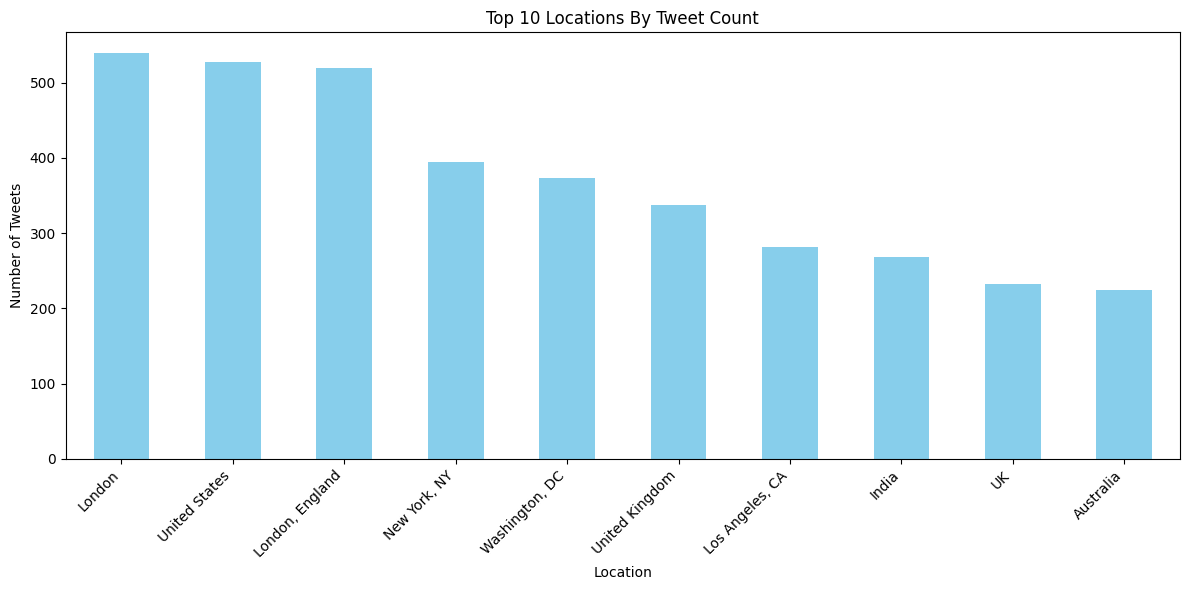

In [175]:
# Get top 10 Tweet locations
top_5_locations = train_df['Location'].value_counts().nlargest(10)

# Plot the number of tweets from the top 5 locations
plt.figure(figsize=(12, 6))
top_5_locations.plot(kind='bar', color='skyblue')
# plt.bar(top_5_locations.index, top_5_locations.values, color='blue', edgecolor='black')
plt.title('Top 10 Locations By Tweet Count')
plt.xlabel('Location')
plt.ylabel('Number of Tweets')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

As expected, London and the United States were definitely the most involved (generally speaking) with the COVID-19 pandemic. One alarming observation is the redundancy in locations (London versus London, England or United States, New York, NY, Los Angeles, CA, etc. are all part of the United States). Although location isn't used in this particular task, for future use of this dataset, it is worth noting.

It doesn't just have to stop at location. Temporal trends can be analyzed to, as it's expected that the public sentiments changed over the period and thus the sentiments might be correlated with time. The following cell explores this temporal relationship.

<Figure size 1200x800 with 0 Axes>

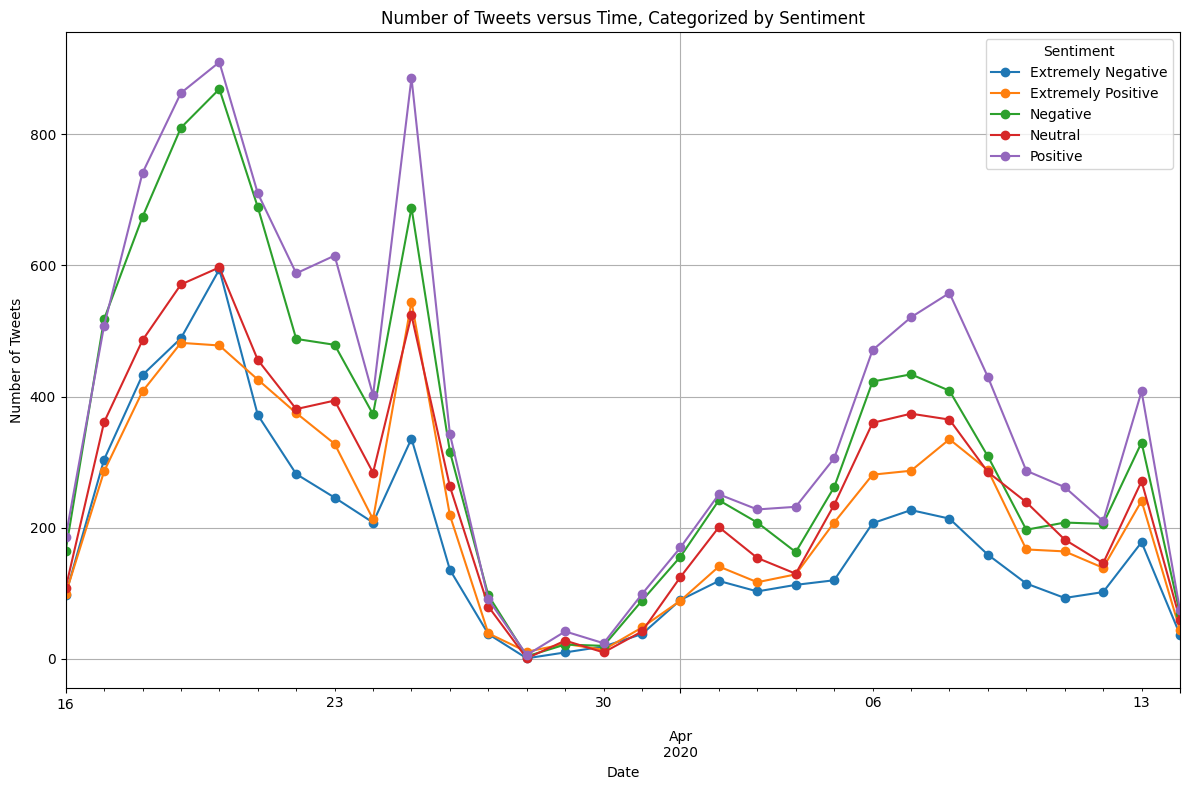

In [178]:
# Analyze temporal trends between number of Tweets of a certain sentiment and the date the Tweet was posted

# Ensure the 'TweetAt' column is in proper datetime format
train_df['TweetAt'] = pd.to_datetime(train_df['TweetAt'])

# Group by date and sentiment to count number of tweets associated with each
temporal_sentiment = train_df.groupby(['TweetAt', 'Sentiment']).size().unstack()

# Plot the temporal trends of sentiment and number of Tweets
plt.figure(figsize=(12, 8))
temporal_sentiment.plot(kind='line', marker='o', figsize=(12, 8))

# Labels, title, grid, etc.
plt.title('Number of Tweets versus Time, Categorized by Sentiment')
plt.xlabel('Date')
plt.ylabel('Number of Tweets')
plt.legend(title='Sentiment')
plt.grid()
plt.tight_layout()
plt.show()

This is an interesting observation. There is a spike in Tweets of all kinds of sentiment in March, and in fact, around mid to late March, they diverge once they peak (with the most Tweets being mostly positive and the least Tweets being extremely negative), then they converge around late March, and then increase to a smaller peak around early to mid April, with the most Tweets being positive and least Tweets being Extremely Negative, essentially mirroring a similar divergence pattern to mid to late March. March 11, 2020 is when the WHO declared pandemic (see https://www.npr.org/2021/03/11/975663437/march-11-2020-the-day-everything-changed), so it makes sense that the number of Tweets began to rise. They most likely settled shortly after before April 2020, around the time where the global economy was expected to contract due to the lockdown. This temporal plot is a great visualization of how the dates can be mapped to real events that affected the number and sentiment of Tweets. One question remains, however: why is it that when the number of Tweets begins to rise and peak, the most Tweets are actually positive, and the least are Extremely Negative? One hypothesis is that there are not as many "extreme" Tweets; observe negative Tweets are also up there during the spikes, but the Neutral Tweets are in the middle, and the extreme sentiment Tweets are the lower bound; this makes sense, as the majority of people express slightly positive or negative sentiments during such emergencies, but few express *very* extreme sentiments. Nonetheless, one must question what it means for a sentiment to be labeled as "extreme". More to come in the ethics section of this notebook.

# Pre-Processing of the Dataset

In this section, the dataset is preprocessed, which is guided by the previous section of exploration of the dataset as well as forthcoming plans for the dataset.

First, there is no need for the Location or TweetAt columns, as the main focus is sentiment analysis on the text itself. This can also help remove bias based on location or time of Tweet.

Moreover, observe that 'Extremely Negative' labels will be treated as 'Negative' and 'Extremely Positive' labels will be treated as 'Positive'. For this task and our group's purpose, the *direction* of the sentiment of a text is of more interest than reaching deep inside the semantic of itself to determine how "extreme" the semantic of the text is. This also helps reduce the class size and address the large imbalance between positive and negative sentiments as was explored in EDA. This is demonstrated in the exercise below.

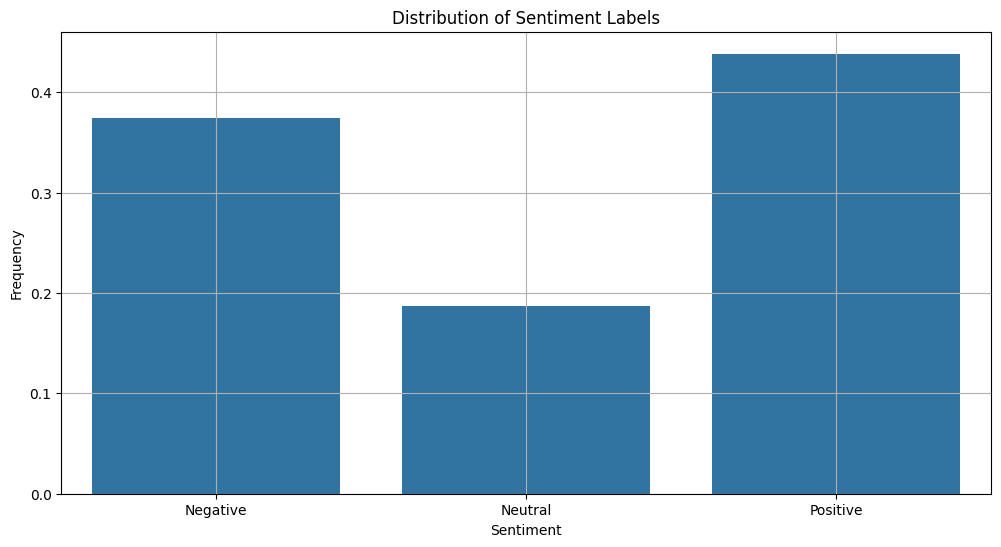

Frequencies of sentiment class distributions:


Sentiment
Negative    0.374128
Neutral     0.187404
Positive    0.438467
Name: Sentiment, dtype: float64

,UserName,ScreenName,OriginalTweet,Sentiment
0,3799,48751,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,3800,48752,advice Talk to your neighbours family to excha...,Positive
2,3801,48753,Coronavirus Australia: Woolworths to give elde...,Positive
3,3802,48754,My food stock is not the only one which is emp...,Positive
4,3803,48755,"Me, ready to go at supermarket during the #COV...",Negative


In [63]:
# Drop the Location and TweetAt columns
train_df.drop(['Location', 'TweetAt'], axis=1, inplace=True)

# Do the same on the test set
test_df.drop(['Location', 'TweetAt'], axis=1, inplace=True)

# Converge extremities in training data
train_df['Sentiment'] = train_df['Sentiment'].replace({
    'Extremely Negative': 'Negative',
    'Extremely Positive': 'Positive'
})

# Converge extremities in test data
test_df['Sentiment'] = test_df['Sentiment'].replace({
    'Extremely Negative': 'Negative',
    'Extremely Positive': 'Positive'
})

sentiment_counts = train_df['Sentiment'].groupby(train_df['Sentiment']).count()
sentiment_frequencies = sentiment_counts / sentiment_counts.sum()

plt.figure(figsize=(12,6))
sns.barplot(x=sentiment_frequencies.index, y=sentiment_frequencies.values)
plt.xlabel('Sentiment')
plt.ylabel('Frequency')
plt.title('Distribution of Sentiment Labels')
plt.grid()
plt.show()

print("Frequencies of sentiment class distributions:")
display(sentiment_frequencies)

display(train_df.head())

Observe that in the above plot, simplifying down to three classes helps address the large class imbalance between negative and positive sentiments. However, there is still a large class imbalance with the netural sentiment labels. This suggests that in future sections, when selecting models and tuning their parameters, F1 score may be of more interest (harmonic mean between precision and recall) compared to accuracy. Also, when evaluating the models, attention will have to be focused on the metrics for neutral sentiment classification due to this class imbalance.

The first step of pre-processing the data involves directly dropping the Location and TweetAt columns in the dataframe. This is because the ultimate objective is to predict the sentiment class based on the Tweet text, which does not depend on the location the Tweet originated from nor the date the Tweet was posted.

Moreover, observe that there is no need for replacing invalid entries with plausible values, since during EDA, it was observed that only the Location column had invalid entries (such as NaN), which is being dropped from the dataframe.

Now, the Sentiment output variable has to be processed. Specifically, it is a categorical variable with 3 categories/classes ("Negative", "Neutral", and "Positive"). In fact, it is an *ordinal categorical variable* since there is a natural order/ranking of the classes (with no exact distance between): "Positive" > "Neutral" > "Negative". Therefore, the following exercise encodes the Sentiment categorical variable with *label encoding* to capture the natural ranking of the categories while transforming them into numerical values that can be processed in machine learning models.

In [64]:
# Define label encoding map for the 5 sentiment classes
sentiment_mapping = {
    "Positive": 2,
    "Neutral": 1,
    "Negative": 0,
}

# Encode the Sentiment column with label encoding
train_df['Sentiment'] = train_df['Sentiment'].map(sentiment_mapping)

# Do the same for test set
test_df['Sentiment'] = test_df['Sentiment'].map(sentiment_mapping)

train_df.head()

,UserName,ScreenName,OriginalTweet,Sentiment
0,3799,48751,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,1
1,3800,48752,advice Talk to your neighbours family to excha...,2
2,3801,48753,Coronavirus Australia: Woolworths to give elde...,2
3,3802,48754,My food stock is not the only one which is emp...,2
4,3803,48755,"Me, ready to go at supermarket during the #COV...",0


Now the Sentiment variable is label encoded. However, the original tweet data is still text data and is not currently fit to be fed into a machine learning model for processing, so it has to be encoded as well. This will be performed in the next section ("Feature Extraction/Feature Learning from the Dataset").

The other pending issue is that during EDA, it was discovered that the Tweet texts contained a lot of common words in the english language (stopwords) as well as irrelevant words such as non-alphanumeric data, URLs, punctuation, etc. The next exercise pre-processes and filters out such characters from the OriginalTweet text data.

In [65]:
def clean_text(text):
  """
  Removes any non-alphanumeric data, URLs, punctuation, and stop words (assuming english language) from the text and replaces with space.

  :param text: the text data to clean
  :return: the cleaned text data
  """
  # remove any URLs from the text data
  text = re.sub(r'http\S+', ' ', text)
  # remove tags
  text = re.sub(r'@\w*', ' ', text)
  # remove hashtags
  text = re.sub(r'#\w*', ' ', text)
  # remove apostrophes
  text = re.sub(r"'s\b", "", text)
  # remove any non-alphanumeric data from the text data
  text = re.sub(r'[^a-zA-Z0-9]+', ' ', text)
  # remove numbers
  text = re.sub('[\d]', ' ', text)
  # convert text to lowercase so it can be compared to stop words
  text = text.lower()
  # remove stop words from the text data
  text = ' '.join([word for word in text.split() if word not in stop_words])
  return text

In [66]:
# Apply the function defined above to each data sample in the training data to clean the Tweet texts
train_df['CleanedOriginalTweet'] = train_df['OriginalTweet'].apply(lambda x : clean_text(x))

# Do the same on the test set
test_df['CleanedOriginalTweet'] = test_df['OriginalTweet'].apply(lambda x : clean_text(x))

# Display the train dataframe with the new column for the clean Original Tweet
train_df.head()

,UserName,ScreenName,OriginalTweet,Sentiment,CleanedOriginalTweet
0,3799,48751,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,1,
1,3800,48752,advice Talk to your neighbours family to excha...,2,advice talk neighbours family exchange phone n...
2,3801,48753,Coronavirus Australia: Woolworths to give elde...,2,coronavirus australia woolworths give elderly ...
3,3802,48754,My food stock is not the only one which is emp...,2,food stock one empty please panic enough food ...
4,3803,48755,"Me, ready to go at supermarket during the #COV...",0,ready go supermarket outbreak paranoid food st...


Now that the Tweet text data was "cleaned", five random samples are taken from the training dataset and displayed below, compared to the original Tweet text and the cleaned Tweet text.

In [67]:
# Print out random 5 original tweet texts and cleaned original tweet texts in the dataframe
sample_rows = train_df.sample(n=5, random_state=123)
for original_tweet_text, cleaned_original_tweet_text in zip(sample_rows['OriginalTweet'], sample_rows['CleanedOriginalTweet']):
  print(f"> Original Tweet Text: {original_tweet_text}\n")
  print(f"> Cleaned Original Tweet Text: {cleaned_original_tweet_text}\n")
  print("-" * 50)

> Original Tweet Text: Four traders have been arrested in Koboko town in Northern Uganda for increasing the prices of their commodities- a packet of salt from Shs 800 to Shs 5,000.
#coronavirus  #COVID19 #COVIDUG

> Cleaned Original Tweet Text: four traders arrested koboko town northern uganda increasing prices commodities packet salt shs shs

--------------------------------------------------
> Original Tweet Text: Definitely expecting the companies already lagging behind their peers on online shopping investment to feel the pinch during COVID-19, especially for mobile experience

> Cleaned Original Tweet Text: definitely expecting companies already lagging behind peers online shopping investment feel pinch covid especially mobile experience

--------------------------------------------------
> Original Tweet Text: The beginning of our week of confinement https://t.co/m8emJT5xPe We have, as of yet, to be in a grocery store or other public place. #coronavirus #covid19

> Cleaned Origin

As shown, after cleaning the tweet text data, there are now no URLs, non-alphanumeric data, punctuation, and stopwords in the text. This will help improve the efficiency and accuracy of the machine learning and language processing tasks that will be explored in a future section. For instance, not only is it removing noise that is most likely uncorrelated with the sentiment of the text, but it is also reducing the number of distinct words and thus eventual features once this text data is numerically transformed (see the feature learning section on vectorization).

However, the text data can be processed further. While less relevant words were cleaned from the text data, recall that in EDA, another noted issue was that similar words or synonyms appeared in the Tweets. This can be approached with lemmatization and stemming, which are text pre-processing techniques used to reduce the inflected forms of words in the text data to a singular common root word (lemma). Both help convert the cleaned text data into a more structured format for processing in the machine learning models, by removing characters from the beginning and end of each word token. The largest distinction between the two methods is that lemmatization guarantees that the processed word is a true existing normalized version/lemma of the word from the dictionary, while stemming simply removes any common suffixes from the end of the word token (see https://www.ibm.com/think/topics/stemming-lemmatization).

The following exercise first lemmatizes the cleaned Tweet text data for each data sample.

In [68]:
def lemmatize_text(text, lemmatizer):
  """
  Lemmatizes the text data.

  :param text: the text data to clean
  :param lemmatizer: the lemmatizer to use
  :return: the lemmatized text data
  """
  # Lemmatize the text
  text = ' '.join([lemmatizer.lemmatize(word) for word in text.split()])
  return text

In [69]:
# Download wordnet from nltk and initialize the lemmatizer
nltk.download('wordnet')
lemmatizer = WordNetLemmatizer()

# Use the function above to lemmatize each cleaned text data sample
train_df['LemmatizedCleanedOriginalTweet'] = train_df['CleanedOriginalTweet'].apply(lambda x : lemmatize_text(x, lemmatizer))

# Do the same for the test set
test_df['LemmatizedCleanedOriginalTweet'] = test_df['CleanedOriginalTweet'].apply(lambda x : lemmatize_text(x, lemmatizer))

# Display the train dataframe with the lemmatized clean Original Tweet
train_df.head()

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\mogil\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


,UserName,ScreenName,OriginalTweet,Sentiment,CleanedOriginalTweet,LemmatizedCleanedOriginalTweet
0,3799,48751,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,1,,
1,3800,48752,advice Talk to your neighbours family to excha...,2,advice talk neighbours family exchange phone n...,advice talk neighbour family exchange phone nu...
2,3801,48753,Coronavirus Australia: Woolworths to give elde...,2,coronavirus australia woolworths give elderly ...,coronavirus australia woolworth give elderly d...
3,3802,48754,My food stock is not the only one which is emp...,2,food stock one empty please panic enough food ...,food stock one empty please panic enough food ...
4,3803,48755,"Me, ready to go at supermarket during the #COV...",0,ready go supermarket outbreak paranoid food st...,ready go supermarket outbreak paranoid food st...


Stemming can also be applied to the text data to further process it and ensure a robust structured form of the text data. Stemming contains different algorithms that vary widely. Nonetheless, the general idea is to remove any word suffixes by comparing each word token again a pre-defined list of common suffixes. Then, the stemmer removes such suffixes from the word token.

In the following exercise, the *Porter stemming algorithm* is used, which based on research, seems to be the most widely used stemming algorithm (see https://www.ibm.com/think/topics/stemming-lemmatization). The Porter stemmer is chosen for this exercise because it only stems English words, which is already the context behind the dataset for this project. Had the Tweets contained other languages such as German, French, Russian, etc., the Snowball stemmer would have been more appropriate (see https://www.ibm.com/topics/stemming#:~:text=First%2C%20while%20the%20Lovins%20and,%2C%20French%2C%20and%20even%20Russian.).

**Note:** for this exercise, lemmatization is the only pre-processing technique used on the text data. This was a design choice during the project since stemming may generally be faster than lemmatization (relies on fixed rules), lemmatization involves querying its dictionary and has more complex algorithms. Since stemming may result in root forms that aren't real words in the english language, lemmatization was preferred as real unseen data (Tweets) is more likely to contain actual english words (lemmas). Still, the below exercise demonstrates how stemming (specifically the Porter stemming algorithm) can be applied to the text data. Also note that it is generally not needed to perform both lemmatization and stemming, and is there is a large overlap in redundancy.

In [70]:
# def stem_text(text):
#   """
#   Stems the text data.

#   :param text: the text data to clean
#   :stemmer: the stemmer to use
#   :return: the stemmed text data
#   """
#   # Initialize the stemmer, which will use the Porter Stemming algorithm
#   stemmer = PorterStemmer()
  
#   # Stem the text
#   text = ' '.join([stemmer.stem(word) for word in text.split()])
#   return text

In [71]:
# # Use the function above to stem each cleaned text data sample - store in a new (stemmed) dataframe so the stemming is not added on top of the lemmatization for comparison
# train_df['StemmedCleanedOriginalTweet'] = train_df['CleanedOriginalTweet'].apply(lambda x : stem_text(x))

# # Do the same for the test set
# test_df['StemmedCleanedOriginalTweet'] = test_df['CleanedOriginalTweet'].apply(lambda x : stem_text(x))

# # Display the train dataframe with the stemmed clean Original Tweet
# train_df.head()

Now, a quick divergence from the purposes of this Project. Soon, there will be a section on feature learning, which will cover how a TF-IDF vectorizer is used to convert the cleaned and processed text data in numerical formats that can be processed by machine learning models. The TF-IDF vectorizer used in that exercise works with raw (non-tokenized) text data and internally performs tokenization on the string. Nonetheless, the below cell demonstrates a very basic notion of what tokenization looks like, which essentially is a form of word tokenization, in which the text is broken up into individual words, which can then be processed and converted into TF-IDF form, etc. (more on this in the feature learning section). One interesting note in the realm of machine learning and natural language processing (NLP), however, is what kind of tokenization is beneficial. For instance, character tokenization may be useful for a language with clear or granular word boundaries, but may make it more difficult to classify text based on solely characters. Word tokenization may be more suited for languages with clear word boundaries (e.g., the english language), and may possibly increase the feature space (compare the distinct number of words in the language compared to characters) while also making it more suited for classifying the meaning of text (see https://www.datacamp.com/blog/what-is-tokenization). This is just a side note, so feel free to ignore this tokenization demonstration.

In [72]:
def tokenize(text):
  tokens = re.findall(r'\b\w+\b', text)
  return tokens

train_df['TokenizedTweet'] = train_df['CleanedOriginalTweet'].apply(lambda x : tokenize(x))
train_df.head()

,UserName,ScreenName,OriginalTweet,Sentiment,CleanedOriginalTweet,LemmatizedCleanedOriginalTweet,TokenizedTweet
0,3799,48751,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,1,,,[]
1,3800,48752,advice Talk to your neighbours family to excha...,2,advice talk neighbours family exchange phone n...,advice talk neighbour family exchange phone nu...,"[advice, talk, neighbours, family, exchange, p..."
2,3801,48753,Coronavirus Australia: Woolworths to give elde...,2,coronavirus australia woolworths give elderly ...,coronavirus australia woolworth give elderly d...,"[coronavirus, australia, woolworths, give, eld..."
3,3802,48754,My food stock is not the only one which is emp...,2,food stock one empty please panic enough food ...,food stock one empty please panic enough food ...,"[food, stock, one, empty, please, panic, enoug..."
4,3803,48755,"Me, ready to go at supermarket during the #COV...",0,ready go supermarket outbreak paranoid food st...,ready go supermarket outbreak paranoid food st...,"[ready, go, supermarket, outbreak, paranoid, f..."


# Feature Extraction/Feature Learning from the Dataset


This section involves feature engineering/learning for this dataset, with the main focus of transforming the raw cleaned/processed Tweet text data into numerical features through a vectorizer.

A couple of notes. First, observe that the original raw data provided from the Kaggle site was already divided into training and test data sets (Corona_NLP_train.csv and Corona_NLP_test.csv). Although this section does not feature cross-validation, thinking ahead, there needs to be a randomization in how the model will be trained on the folds in the data to find the optimal set of parameters. In the exercise below, this is achieved with the sample() function call on the training dataframe, which will randomly shuffle the rows (data samples). There is no need for a randomized train and test split since the models can train on the entire training data as there is a separate test data set provided from the source.

In [73]:
# Shuffle the data to prevent bias
shuffled_train_df = train_df.sample(frac=1, random_state=42).reset_index(drop=True)

Next, the feature matrix (X_train_lemmatized) and target vector (y_train) must be filtered from the training data frame. Currently, there is one feature/predictor, in X_train_lemmatized, as it contains text data. The only target is the sentiment label in y_train. Observe this same process is mirrored for the test data, however the test data is never touched until evaluation of classifiers in the final section of this notebook.

In [74]:
X_train_lemmatized = shuffled_train_df["LemmatizedCleanedOriginalTweet"]
# X_train_stemmed = shuffled_train_df["StemmedCleanedOriginalTweet"]
y_train = shuffled_train_df["Sentiment"]

# Same for test set
X_test_lemmatized = test_df["LemmatizedCleanedOriginalTweet"]
# X_test_stemmed = test_df["StemmedCleanedOriginalTweet"]
y_test = test_df["Sentiment"]

Now, it is time for the actual feature extraction. In natural language processing (NLP), machine learning models can not just work with raw text data as humans can; the text data has to be transformed into a numerical representation. In its current form, the text data in X_train_lemmatized is just a string of a sequence of words and/or sentences. Transforming the text data into a numerical representation is achieved through the process of **vectorization**.

Two of the most common techniques include the **bag-of-words**, **n-grams** (which was briefly discussed in the EDA section), and **TF-IDF**. In the bag-of-words approach, each distinct word within a document has its occurences counted and turned into a vector, which can they be compared to the vectors of other documents to cluster or classify based on their similarity. For instance, consider the feature names $p = ["i", "am", "the", "best", "of", "coder"]$, and there are two documents (in this context, Tweets) $d_1 = ["i", "am", "the", "best", "of", "the", "best"]$ and $d_2 = ["i", "am", "the", "best", "coder"]$. Then, the numerical representation using bag-of-words $BOW(d_i)$ of these two documents based on the features is $BOW(d_1) = [1,1,2,2,1,0]$ and $BOW(d_2) = [1,1,1,1,0,1]$. One important detail with this approach is that it does not use frequency, and thus the vectors are not normalized; this can lead to more common words dominating the weights and actually resulting in failed convergence of numerous algorithms. In fact, this is why the TF-IDF approach is used in this project, which was another design choice made.

In Term Frequency-Inverse Document Frequency (TF-IDF), a matrix with the "significance" of each word per document within the corpus (collection of documents) is created, using the TF-IDF formula which scales the Term Frequency (TF) and Inverse Document Frequecy (IDF) for each word. The features created are similar in terms of the distinct words such as in bag-of-words, but the values are now normalized to an extent. The TF-IDF formula for term $x$ in document $d$ is given by:
$w_{x,d} = tf_{x,d} \times \log(\displaystyle\frac{N}{df_x})$ where $N$ is the total number of documents in the corpus and $tf_{x,d}$ is the frequency of term $x$ in document $d$ and $df_{x}$ is the number of documents that contain the term $x$.

Due to the practical constraint of this problem (there are already thousands of samples), using N-grams would have resulted in far more dimensions compared to TF-IDF. In fact, it could lead to the "curse of dimensionality" as N increases (bi-grams, tri-grams, etc.), leading to more sparsity and a very computationally expensive feature space, which would affect accuracy and performance. Since N-grams can capture local patterns (e.g., word sequences), however, it would be interesting to try to implement a neural network with Long Short Term Memory (LSTM), for instance, to enable context of the sentiment analysis. TF-IDF can still, however, emphasize individual terms and their significance and relevance across documents, which is plentiful for the task at hand.

In the exercise below, the TfidfVectorizer is used from scikit-learn, which converts the collection of cleaned and processed Tweet text data into the TF-IDF matrix discussed earlier (see https://scikit-learn.org/1.5/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html).

The call to API method fit_transform essentially learns the vocabulary (the distinct words) in the collection of Tweet texts in X_train_lemmatized and returns the document-term matrix (in other words, a more efficient implementation of fitting to the data and then transforming it). Pay particular attention to the API call made to transform(), which is done on the *test* collection of Tweet texts stored in X_test_lemmatized. This is because once the vectorizer is fitted and has the new feature space (the vocabulary of words) from the training data collection of Tweet texts, it should only be used to transform (and not learn again) the collection of documents or Tweet texts in the test data to the document-term matrix. This ensures the number of features (again, learned from the training data) stays consistent between the training and testing data. In some ways, this is very similar to the example in the course, where the test data is de-seasonalized using the training data. Observe this avoids any data leakage, as the training data is used to vectorize the test data, and not the other way around.

In [75]:
# Fit the TF-IDF Vectorizer on the lemmatized training data and transform both the train and test data using the vectorization (no data leakage b/c training data is used for transform)
tfidf_lemmatized_vectorizer = TfidfVectorizer()
X_train_lemmatized_tfidf = tfidf_lemmatized_vectorizer.fit_transform(X_train_lemmatized)
X_test_lemmatized_tfidf = tfidf_lemmatized_vectorizer.transform(X_test_lemmatized)
print(f"Lemmatized TF-IDF X_train_lemmatized_tfidf has {X_train_lemmatized_tfidf.shape[0]} data samples and {X_train_lemmatized_tfidf.shape[1]} features.")
# print(f"Stemmed, TF-IDF X_train has {X_train_stemmed_tfidf.shape[0]} data samples and {X_train_stemmed_tfidf.shape[1]} features.")
print(f"Lemmatized TF-IDF X_test_lemmatized_tfidf has {X_test_lemmatized_tfidf.shape[0]} data samples and {X_test_lemmatized_tfidf.shape[1]} features.")

Lemmatized TF-IDF X_train_lemmatized_tfidf has 41157 data samples and 28708 features.
Lemmatized TF-IDF X_test_lemmatized_tfidf has 3798 data samples and 28708 features.


As displayed above, observe that the feature matrix still has 41,157 data samples as with the original training data (no Tweet text was lost in this process). However, observe that the feature space has greatly expanded, from a size of one feature (the processed text data in X_train_lemmatized), to a size of 28,708 features in X_train_lemmatized_tfidf, the TF-IDF vectorized feature matrix. This should not come as a surprise, since the TF-IDF vectorizer fit on the training data and discovered a vocabulary feature space of 28,708 distinct tokens from the collection of processed Tweet texts, and then transformed the feature matrix into the new feature space, in TF-IDF vectorized form (and also transformed the test feature matrix, which also has the same size, as checked above). Now, imagine if the text pre-processing stage had not dealt with removing stop words and cleaning the text; the feature space would have been even more massive!

One more note on a key observation. The feature space is clearly gigantic, but there are also 41,157 data samples from the training data. It is reasonable to assume each document (processed Tweet text) won't have thousands of the exact same words except for a key distinct few terms that may correlate with their sentiment. This means that for a large majority of the transformed feature matrix, a lot of the TF-IDF frequencies will be 0, despite all the previous data cleaning and pre-processing efforts. This is checked in the exercise below.

In [76]:
# Checking for the sparsity of the transformed TF-IDF vectorized feature matrix (training)
non_zeros_train = (X_train_lemmatized_tfidf != 0).sum()
total_train = X_train_lemmatized_tfidf.shape[0] * X_train_lemmatized_tfidf.shape[1]
print("TRAINING FEATURE MATRIX:")
print(f"There are {non_zeros_train} non-zero elements.")
print(f"There are {total_train} total elements.")
print(f"Sparsity: {1 - (non_zeros_train / total_train):.2%}")

# Checking for the sparsity of the transformed TF-IDF vectorized feature matrix (test)
non_zeros_test = (X_test_lemmatized_tfidf != 0).sum()
total_test = X_test_lemmatized_tfidf.shape[0] * X_test_lemmatized_tfidf.shape[1]
print("\nTEST FEATURE MATRIX:")
print(f"There are {non_zeros_test} non-zero elements.")
print(f"There are {total_test} total elements.")
print(f"Sparsity: {1 - (non_zeros_test / total_test):.2%}")

TRAINING FEATURE MATRIX:
There are 603665 non-zero elements.
There are 1181535156 total elements.
Sparsity: 99.95%

TEST FEATURE MATRIX:
There are 58071 non-zero elements.
There are 109032984 total elements.
Sparsity: 99.95%


Thus, the feature matrices in the training and test data, after TF-IDF vectorization, are *very sparse*. Upon further research, this is a very common situation with natural language processing (NLP), as that is the nature of text across a very large collection of documents (in this context, Tweets). It will be interesting to explore its implications in how the models compare in evaluation in the next section.

# Processing of the Dataset Using Two Different Machine Learning Methods

In this section, the declared task of classifying a Tweet by predicting its sentiment is carried out using two different machine learning methods: Logistic Regression and Random Forest Classifier.

This section also presents tuning of both models using cross-validation, with the results averaged over multiple validation folds.

The final results are presented at the end of this section.

## K-Fold Cross Validation
As will be discussed shortly, both models used have some parameters that can be tuned to achieve as good of a performance as possible (within time and resource constraints, of course). The function in the cell below, $\texttt{get\textunderscore kfolds}$, performs K-Fold Cross Validation. Recall from earlier sections that the original Kaggle site already provided a separate training and test dataset. Thus, there is no need for a train-test split and stratification as is usually done for cross validation on one dataset, as the entire training data can be used to both cross-validate and train the final models with their respective chosen parameters. Recall that the training data has already been shuffled at this point.

For the K-Fold Cross Validation, a value of K=5 has been chosen as it provides a good balance between computational efficiency and a reliable estimate on model performance on validation sets. Using K-Fold Cross Validation helps guarantee that each data point in the training data is used only once for testing.

The $\texttt{get\textunderscore kfolds}$ function in the cell below returns the indices of all K iterations of K-Folds Cross Validation (essentially denoting the test fold and training folds for each iteration). The fold length is simply the number of data samples split into K folds. For each of the K iterations, there is 1 test fold and 4 train folds, and they translate "up" the data matrix each iteration. For each iteration, the function tracks the starting and ending index of the test fold, as well as the starting and index of each train fold.

In [77]:
def get_kfolds(data, k=5):
  """
  Generates k-folds on the data.
  """
  fold_length = data.shape[0] // k # Size of each fold
  kfolds = [] # Stores tuples containing the indices for the test fold and train folds for each iteration i = 0, 1, 2, ... , k-1
  fold_indices = np.arange(data.shape[0]) # indices of the data
  for i in range(k):
    test_fold = fold_indices[i * fold_length : (i + 1) * fold_length] # test fold indices
    train_folds = np.concatenate([fold_indices[ : i * fold_length], fold_indices[(i + 1) * fold_length : ]]) # indices of train folds (possibly before and after test fold)
    kfolds.append((train_folds, test_fold)) # store the indices of test fold and train folds for current iteration
  return kfolds # return all fold indices for all K iterations of cross validation

Now that a function for getting the indices for the K folds in each of the K iterations is defined, a second function, $\texttt{kfolds\textunderscore CV}$, in the cell below, is used to run K-Folds Cross Validation to tune the parameters of a model. As a high-level overview, K-Folds Cross Validation involves the K iterations through the K folds. At every iteration, as already stated, there is 1 test fold and 4 train folds, so the model with the current sent of parameters trains on those 4 train folds, and then predicts the sentiment labels on the test fold. The function allows specifying a metric to track this performance (accuracy, F1 score, etc.). This repeats for each iteration, where each time the model is evaluated on entirely new data points *from the training data*. At the end of the K iterations, the *average of the metric* is computed and stored to be associated with the current set of parameters of the model. This process repeats and loops through all combinations of specified parameters for the model. In other words, this essentially performs a **grid search**, via Cross Validation (CV), across a local grid of parameters for the model, and attempts to *maximize* the average metric obtained from K-Fold Cross Validation on that set of model parameters. The function also tracks the time for a run of K-Fold CV for each set of model parameters for future evaluation and analysis. A table is also printed out at the end, summarizing the average metrics and run times associated with each set of model parameters, with the (locally) optimal set of parameters highlighted in green (reference the outputs below).

One important note here is the idea of "local search" in this grid search of optimal model parameters. Given infinite time and resource constraints, one could just set a vast search grid and run the below function until the true global optimal parameters for the model are found. However, given time and resource constraints, the best approach found was trial and error combined with domain expertise. By researching both models and the types of parameters that can be tuned, and considering the context of the task (for instance, dealing with very sparase data in very high dimensions), appropriately-sized grids were defined (reference below).

This is essentially achieving what sci-kit learn's GridSearchCV was defined to do, which is performing an exhaustive search over the specific parameters. The GridSearchCV utilizes a "fit" and "score" method where the model's parameters are used to apply such methods by optimizing them via a cross-validated grid search (see https://scikit-learn.org/dev/modules/generated/sklearn.model_selection.GridSearchCV.html). Nonetheless, it was interesting to implement this process from scratch, and has ultimately reinforced the inner workings of K-Fold Cross Validation and tuning the parameters of a model.

In [78]:
from itertools import product

def kfolds_CV(X, y, params, table_title, metric=accuracy_score, model_type=None):
    """
    Performs an exhaustive grid search over the specified parameters to optimize the average metric of the classifier.
    
    :param X: the feature matrix
    :param y: the target vector or matrix
    :table_title: title for the table summarizing results
    :param metric: the metric used to choose optimal parameters upon cross-validation
    :param model_type: the model being used (currently supports LogisticRegression, RandomForestClassifier)
    :return: optimal set of parameters for the model
    """
    # storing results per combination of parameters and best results
    best_params = None
    best_score = 0
    results = []
    param_combinations = list(product(*params.values()))
    param_types = list(params.keys())
    
    # Go through each combination of parameters (grid search)
    for param_combination in param_combinations:
        param_dictionary = dict(zip(param_types, param_combination)) # stores the combination of parameters
        
        if not model_type:
            break
        
        model = None
        
        # Initialize the models with the current combination of parameters
        # Note: LogisticRegression has some solvers that are incompatible with the penalty
        if model_type == "LogisticRegression":
            if param_dictionary['penalty'] == 'l1' and param_dictionary['solver'] not in ['liblinear', 'saga']:
                continue
            model = LogisticRegression(C=param_dictionary['C'], penalty=param_dictionary['penalty'], solver=param_dictionary['solver'])
        elif model_type == "RandomForestClassifier": # Random Forest Classifier
            model = RandomForestClassifier(n_estimators=param_dictionary['n_estimators'], max_features=param_dictionary['max_features'])
        else: # Only supports LogisticRegression and RandomForestClassifier for now
          continue

        # Track the scores and time
        scores = []
        start_time = time.time()

        # Run K-Fold Cross Validation on this set of parameters
        for train_folds, test_fold in get_kfolds(X):
            # Get the fold indices
            X_train_fold, y_train_fold = X[train_folds], y[train_folds]
            X_test_fold, y_test_fold = X[test_fold], y[test_fold]
            
            # Train the model on the train folds
            model.fit(X_train_fold, y_train_fold)

            # Evaluate the model on the test fold
            y_pred = model.predict(X_test_fold)
            
            # Get the metric of the model on the test fold (how "good" model is for this fold)
            score = metric(y_test_fold, y_pred)
            
            # Track the score
            scores.append(score)

        # Compute the time it took to run K-Fold Cross Validation for this combination of parameters
        end_time = time.time()
        run_time = end_time - start_time

        # Get the average metric score and add to results
        avg_score = np.mean(scores)
        results.append({"params": param_dictionary, "score": avg_score, "time(sec)": run_time})

        print(results[-1]) # print the most recent combination of parameters evaluated

        # Always track the set of parameters that resulted in best average metric across the test folds
        if avg_score > best_score:
            best_score = avg_score
            best_params = param_dictionary
            
    print(f"\nBest Parameters: {best_params}")
    print(f"Best Score: {best_score:.4f}\n")
    
    # Plot a summary of cross-validation results
    rows = []
    for res in results:
        row = res['params'].copy()
        row['score'] = res['score']
        row['time(sec)'] = res['time(sec)']
        rows.append(row)
        
    df = pd.DataFrame(rows)    
    fig, ax = plt.subplots(figsize=(10, len(df) * 0.5))
    ax.axis('tight')
    ax.axis('off')
    table = ax.table(cellText=df.values, colLabels=df.columns, loc='center', cellLoc='center')
    
    # Highlight the best combination of params determined through CV
    for col in range(len(df.columns)):
        table[(df['score'].idxmax() + 1, col)].set_facecolor('#ccffcc') # make it a green background
        
    ax.set_title(table_title, fontsize=16, weight='bold', pad=18)
    
    plt.show()
    
    return best_params, best_score

## Logistic Regression

Regularized Multinomial Logistic Regression was chosen as the first machine learning model for the task of predicting the sentiment of Tweets. In Multionomial Logistic Regression, binary logistic regression is extended for handling multiple classes (3 - positive, neutral, negative). 

Instead of one decision boundary, it will model probabilities for each class using the **softmax function**. The main objective of this model is to predict class label $y=\{1,2,...,M\}$ for given input (vectorized TF-IDF Tweet text) $\mathbf{X} \in \mathbb{R}^p$ for $p$ dimensions.

The model predicts the probability $P(y=m |\mathbf{X}) = \displaystyle\frac{\exp(\mathbf{W}_m^{\text{T}}\mathbf{X} + b_m)}{\sum_{j=1}^{M}\exp(\mathbf{W}_j^{\text{T}}\mathbf{X} + b_j)}$, with weight vector $\mathbf{W}_m$ and bias $b_m$ for every class $m$. Then, the predicted class is taken as the one with highest probability: $\widehat{y} = \mathop{\arg\max}_m P(y=m | \mathbf{X})$.

The loss function used in the multinomial logistic regression model essentially uses cross-entropy loss together with a regularization term for parameterizing model complexity further under constraint: $L(\mathbf{W}, b) = -\displaystyle\frac{1}{N}\displaystyle\sum_{i}^{N}\displaystyle\sum_{m=1}^{M} y_{i,m}\log P(y=m | \mathbf{X}_i) + \displaystyle\frac{1}{2}\lambda ||\mathbf{W}||_p^p$ for $N$ data training samples, $y_{i,m}$ as an indicator of 1 if sample $i$ is class $m$ and 0 otherwise, $P(y=m | \mathbf{X}_i)$ as the posterior probability of class $m$ for sample $i$, the regularization parameter $\lambda = 1 / C$, and $||\mathbf{W}||_p^p$ as the regularization term, where $p=2$ for L2 regularization and $p=1$ for L1 regularization.

In particular, the below implementation uses the Scikit-learn's LogsticRegression model and API calls. By default, because the data has more than two classes, the model is multinomial. The three main parameters of focus for training the model are 'C', 'penalty', and 'solver'. The 'C' parameter indicates the inverse of the regularization strength ($1/\lambda$), where $\lambda$ is the regularization parameter. Smaller values of $C$ lead to more regularization by penalizing large coefficients to prevent overfitting. Meanwhile, larger values of 'C' allow the model to fit the data more closely, which can overfit. The 'penalty' parameter is the type of regularization applied. 'l1' indicates lasso regularization, which promotes coefficient sparsity, which is crucial for this context where the data is sparse and the feature space (in vectorized TF-IDF form) is vast. 'l2' indicates ridge regularization, which penalizes large coefficients without any constrained force on sparsity necessarily. The 'solver' parameter indicates the type of optimization algorithm used for minimizing the loss function. The 'liblinear' solver is a linear optimizer that is efficient for small datasets and supports both L1 and L2 regularization. The 'newton-cg' optimizer is the Newton Conjugate Gradient optimizer, which works best on small datasets as well but only supports L2 regularization. The 'sag' solver is the Stochastic Average Gradient optimizer, which is efficient on larger datasets, but also only supports L2 regularization.

The training process involves the model fitting the data by adjusting the weights $\mathbf{W}$ and biases $b$ to minimize the regularized loss function, with the 'solver' acting as the optimization technique. In this optimization process, overfitting is discouraged for higher regularization, as the larger coefficients in $\mathbf{W}$ are penalized. Lastly, the softmax function allows for multinomial prediction of the probabilities of each class for a data sample and the ultimate chosen class for the sample is simply the one that maximizes the probability: $\widehat{y} = \mathop{\arg\max}_m P(y=m | \mathbf{X})$.

In the code cell below, a local grid search is expanded over the 'C', 'penalty', and 'solver' parameter combinations to choose the best set of parameters based on K-fold cross validation, as discussed earlier. Observe that given more time, the grid search can be expanded for a larger range of parameter values and solvers, but the below was sufficient in achieving good accuracy through trial and error. It really comes down to a practical design choice in tuning and training a model.

(see https://scikit-learn.org/1.5/modules/generated/sklearn.linear_model.LogisticRegression.html).

{'params': {'C': 0.01, 'penalty': 'l1', 'solver': 'liblinear'}, 'score': 0.2784292894521889, 'time(sec)': 0.5213832855224609}
{'params': {'C': 0.01, 'penalty': 'l2', 'solver': 'liblinear'}, 'score': 0.37480732437368486, 'time(sec)': 1.9386520385742188}
{'params': {'C': 0.01, 'penalty': 'l2', 'solver': 'newton-cg'}, 'score': 0.41470041230113514, 'time(sec)': 0.7054042816162109}
{'params': {'C': 0.01, 'penalty': 'l2', 'solver': 'sag'}, 'score': 0.4147446165418412, 'time(sec)': 1.3562543392181396}
{'params': {'C': 0.1, 'penalty': 'l1', 'solver': 'liblinear'}, 'score': 0.5361766434747098, 'time(sec)': 1.0970346927642822}
{'params': {'C': 0.1, 'penalty': 'l2', 'solver': 'liblinear'}, 'score': 0.5554167793766556, 'time(sec)': 2.8351809978485107}
{'params': {'C': 0.1, 'penalty': 'l2', 'solver': 'newton-cg'}, 'score': 0.612282532172763, 'time(sec)': 0.9901919364929199}
{'params': {'C': 0.1, 'penalty': 'l2', 'solver': 'sag'}, 'score': 0.6119044483265694, 'time(sec)': 1.3587019443511963}
{'param

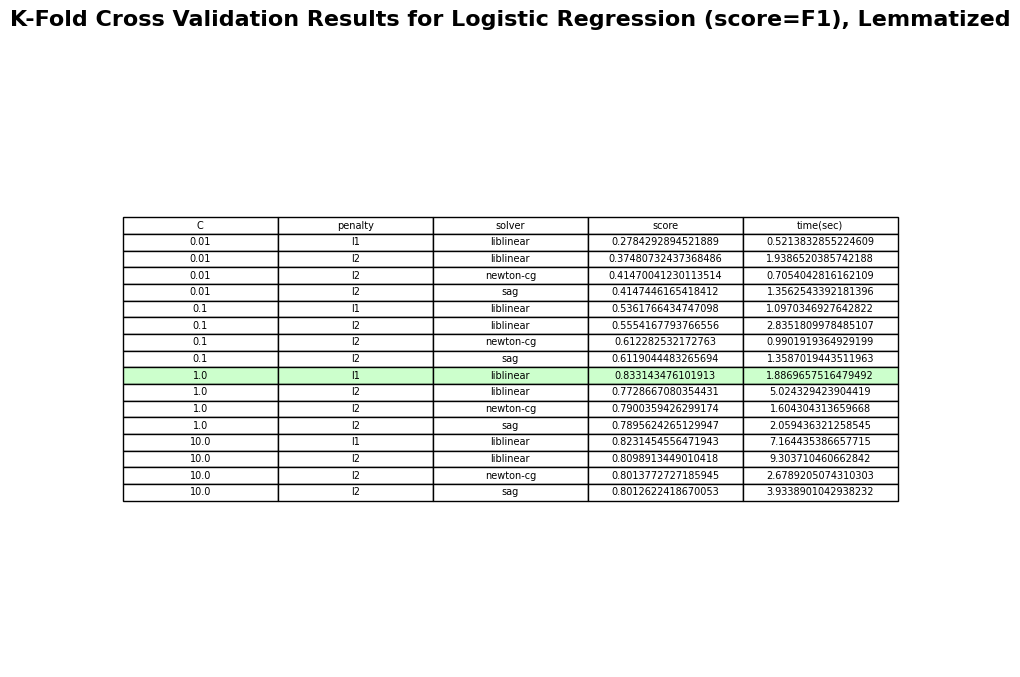

In [79]:
lr_params = {'C': [0.01, 0.1, 1.0, 10.0],
          'penalty': ['l1', 'l2'],
          'solver': ['liblinear', 'newton-cg', 'sag']}

# Here, we use f1-score metric and run cross validation for lemmatized
lr_best_params_lemmatized_f1, lr_best_score_lemmatized_f1 = kfolds_CV(X_train_lemmatized_tfidf, y_train, lr_params, "K-Fold Cross Validation Results for Logistic Regression (score=F1), Lemmatized", lambda y_true, y_pred: f1_score(y_true, y_pred, average='macro'), "LogisticRegression")

Thus, the optimal set of parameters discovered was 'C' = 1.0, 'penalty' = 'l1', and the 'solver' was 'liblinear', resulting in an average F1 score of 83.3% across the validation folds during K-fold cross validation. Observe that interestingly, higher values of C led to better average validation scores compared to lower values of C. This might suggest that the true relationship bewteen the vast features and number of samples is complex, and excessive regularization (lower values of C) is oversimplying and underfitting the model, resulting in poorer performance. However, regularizing too little (large C) also seems to cause a decrease in accuracy, suggesting overfitting on the training data. The best optimal choice of parameters seems to be C = 1.0 with L1 regularization, with the liblinear optimization method.

## Random Forest Classifier

A Random Forest Classifier is an ensemble learning method using for tasks related to classification. It builds a combination of numerous **decision trees** using different subsets of the data, using techniques such as **bagging** to optimize prediction accuracy and avoid overfitting. For each tree, there is an independent prediction of the class for a given input (in this context, the vectorized TF-IDF format of the processed text data), with the final prediction using a majority class vote across each tree. In order to optimize how diverse the trees in the forest are, randomization in sampling of the training data is used for each tree (such as bootstrap aggregation techniques) as well as sampling of subsets of features every time the decision trees split.

In order to make a decision, every decision tree is first trained on a bootstrapped sample of the data, and then a random subset of features is selected from each tree split; this allows for the trees to be more diverse and capture possibly more variance and complex features in the data. Now, when given a new input, every tree will predict a class based on its random subset of considered features and the majority vote among the trees becomes the predicted class.

As shown in the code cell below, Sci-kit learn's RandomForestClassifier model and API calls were used to implement the model. The two main parameters of interest were 'n_estimators' and 'max_features'. The 'n_estimators' parameter is associated with the number of tree estimators (decision trees) created in the forest. A higher number of estimators can generally improve model performance (see results below) as it reduces variance with more diverse aggregation, but also greatly increases the training time (again, see results below). The default for Sci-kit learn is set to 'n_estimators=100'. The 'max_features' parameter is associated with the number of features viewed at each split (i.e., how many features to randomly choose). This is another importance tunable parameter because it influences the balance between the model's performance and capturing diverse variance. Using smaller 'max_features' like 'sqrt' ($\displaystyle\sqrt{\text{p}}$ for $p$ features) increases the diversity of the decision trees and reduces the correlation between them, but also means that more bias is introduced. Using larger 'max_features' like 'log2' or even up to the total number of features allows for a more conservative strategy, as it reduces bias but can also allow for more correlation between the decision trees which can quickly cause diminishing returns on the point of using an ensemble learning method.

During training, there is first the bootstrap sampling, in which a random sample with replacement from the training data is taken to train each decision tree. Then, the features at each split are randomly chosen (see 'max_features') to optimize the split. Then, every decision tree begins to grow until there is some termination (can't split anymore, reached maximum depth, etc.), which by default, is until the maximum depth point. Then, for the actual ensemble prediction, when given a data sample $\mathbf{X}$, every decision tree predicts a class $y_i$ where $i$ is the decision tree index, and the final prediction for the class is chosen with majority voting: $\widehat{y} = \mathop{\text{mode}}\{y_1,y_2,...,y_{\text{n\textunderscore estimators}}\}$.

(see https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html).

Random Forest Classifier was chosen as the second model because of three main advantages based on independent research. First, overfitting can be reduced as bagging and randomizing feature selection for each split avoids more correlation between the decision trees and thus overfitting when compared to using a singular branching control sequence. This also means the model is more robust to outliers and noise due to the ensemble voting system. It can also be seen that because the parameters are so tunable, it is easy to choose a valid combination that balances scaling with the size of the dataset (especially for this project, where there are thousands of samples and features after TF-IDF vectorization) and training time.

In the code cell below, a local grid search is expanded over the 'n_estimators' and 'max_features' parameter combinations to choose the best set of parameters based on K-fold cross validation, as discussed earlier. Observe that given more time, the grid search can be expanded for a larger range of parameter values, but the below was sufficient in achieving good accuracy through trial and error. It really comes down to a practical design choice in tuning and training a model, which was the same with the Logistic Regression model.

**WARNING:** the process below can around 40 minutes to tune the parameters of the RandomForestClassifier, depending on hardware resources; do NOT clear the cell output unless a re-run of the experiment is required, but pay attention to this warning as re-tuning the parameters will take a significant amount of time.

{'params': {'n_estimators': 10, 'max_features': 'log2'}, 'score': 0.6320995148440627, 'time(sec)': 81.71669030189514}
{'params': {'n_estimators': 10, 'max_features': 'sqrt'}, 'score': 0.6887610917563146, 'time(sec)': 71.62657642364502}
{'params': {'n_estimators': 50, 'max_features': 'log2'}, 'score': 0.7128248309027831, 'time(sec)': 404.36925292015076}
{'params': {'n_estimators': 50, 'max_features': 'sqrt'}, 'score': 0.7319178956642187, 'time(sec)': 341.6254868507385}
{'params': {'n_estimators': 100, 'max_features': 'log2'}, 'score': 0.7286194106886079, 'time(sec)': 800.4679760932922}
{'params': {'n_estimators': 100, 'max_features': 'sqrt'}, 'score': 0.739015692869458, 'time(sec)': 699.865549325943}

Best Parameters: {'n_estimators': 100, 'max_features': 'sqrt'}
Best Score: 0.7390



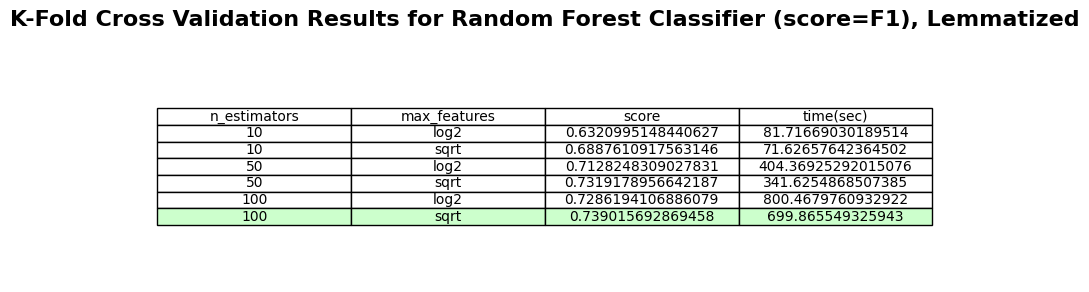

In [80]:
rf_params = {'n_estimators': [10, 50, 100],
             'max_features': ["log2", "sqrt"]}

rf_best_params_lemmatized_f1, rf_best_score_lemmatized_f1 = kfolds_CV(X_train_lemmatized_tfidf, y_train, rf_params, "K-Fold Cross Validation Results for Random Forest Classifier (score=F1), Lemmatized", lambda y_true, y_pred: f1_score(y_true, y_pred, average='macro'), "RandomForestClassifier")

Thus, the optimal set of parameters discovered was 'n_estimators' = 100 and 'max_features' = 'sqrt', resulting in an average F1 Score of 73.9% across the validation folds during K-fold cross validation. Observe that as the number of estimators (trees) increases, the average F1 score keeps increasing, which indicates having more decision trees allows for reduced variance in predictions and thus better generalization on the validation folds. It is predicted, however, given sufficient time to experiment, continually increasing the number of estimators would eventually lead to too much increased computational cost to be considered efficient. Similarly, it seems like using 'sqrt' for 'max_features' resulted in better average F1 score, as smaller values tend to favor diversity and generalization while larger values tend to fit the data better. However, the differences in accuracies between the 'max_features' is not too large, and given more time, experimentation with more 'max_features' parameter values would yield further insight.

Below, based on the results of tuning the parameters, the two models are instantiated and trained on the *entire* training dataset, using the optimal set of parameters determined through cross validation.

In [81]:
# Train the models on the entire training data

# LR: lemmatized, Best Parameters: {'C': 1.0, 'penalty': 'l1', 'solver': 'liblinear'}
# Best Score: 0.6217
print("Training Logistic Regression model on all training lemmatized data")
lr_model = LogisticRegression(C=1.0, penalty='l1', solver='liblinear')
start_time = time.time()
lr_model.fit(X_train_lemmatized_tfidf, y_train)
end_time = time.time()
training_time = end_time - start_time
print(f"Finished training {lr_model} model in {training_time:.3f}s.\n")

# RF: lemmatized, Best Parameters: {'n_estimators': 100, 'max_features': 'sqrt'}
# Best Score: 0.5447
print("Training Random Forest Classifier model on all training lemmatized data")
rf_model = RandomForestClassifier(n_estimators=100, max_features='sqrt')
start_time = time.time()
rf_model.fit(X_train_lemmatized_tfidf, y_train)
end_time = time.time()
training_time = end_time - start_time
print(f"Finished training {rf_model} model in {training_time:.3f}s.\n")

Training Logistic Regression model on all training lemmatized data
Finished training LogisticRegression(penalty='l1', solver='liblinear') model in 0.562s.

Training Random Forest Classifier model on all training lemmatized data
Finished training RandomForestClassifier() model in 120.478s.



Observe how the Random Forest Classifier took much more time to train on the dataset compared to the Logistic Regression Model. Reference the previous discussion on choosing the number of decision trees in a Random Forest Classifier.

# Comparative Analysis of the Two Methods on the Dataset

This section covers a detailed comparison between the two machine learning models for the dataset across dimensions including computational complexity, performance, etc., as well as a final recommendation on the method that should go into production for this dataset.

The cell below uses the trained models (using the best set of tunable parameters discovered for each) to get the sentiment predictions on the test data, which recall from before, is already a TF-IDF vectorized version of the processed (cleaned, lemmatized, etc.) version of the original raw text data. This will be used in evaluating and comparing the two models shortly.

In [188]:
start_time = time.time()
y_pred_lr = lr_model.predict(X_test_lemmatized_tfidf)
end_time = time.time()
run_time = end_time - start_time
print(f"Logistic Regression prediction took {run_time:.3f}s.")

start_time = time.time()
y_pred_rf = rf_model.predict(X_test_lemmatized_tfidf)
end_time = time.time()
run_time = end_time - start_time
print(f"Random Forest Classifier prediction took {run_time:.3f}s.")

Logistic Regression prediction took 0.001s.
Random Forest Classifier prediction took 0.309s.


The cell below features utility functions that will be used to help evaluate and compare the two models.

The $\texttt{create\textunderscore confusion\textunderscore matrix}$ function takes in the true sentiment labels and the model's predicted labels and M (the number of classes) and constructs a confusion matrix (non-normalized), where the true labels are rows and predicted labels are columns.

The $\texttt{normalize\textunderscore confusion\textunderscore matrix}$ function takes in a confusion matrix and normalizes it by row (i.e., the true label).

The $\texttt{compute\textunderscore metrics\textunderscore from\textunderscore confusion\textunderscore matrix}$ function uses the passed in confusion matrix to compute the various metrics. It first computes the number of True Positives, False Positives, False Negatives, and True Negatives. It then computes the Precision, Recall, F1 Score, and Support.

The $\texttt{compute\textunderscore macro\textunderscore and\textunderscore weighted\textunderscore averages\textunderscore of\textunderscore metrics}$ function computes the macro (simply average) and weighted (using weights as the support, or number of occurences of the sentiment label) averages of the metrics.

The $\texttt{plot\textunderscore confusion\textunderscore matrix}$ function simply plots a heatmap visualization of the confusion matrix.

The $\texttt{plot\textunderscore classification\textunderscore metrics}$ function plots a side-by-side comparison of the various metrics from both models.

The $\texttt{plot\textunderscore avg\textunderscore metrics}$ function plots a side-by-side comparison of the average metrics (macro and weighted averages) between the two classifiers.

Reference the code and comments for more details and implementation.

In [99]:
def create_confusion_matrix(y_true, y_pred, M):
    """
    Creates an MxM confusion matrix for M classes.
    
    :param y_true: true class labels
    :param y_pred: predicted class labels
    :return: confusion matrix of size MxM
    """
    confusion_mat = np.zeros((M, M), dtype=int) # initialize confusion matrix MxM
    for true, predicted in zip(y_true, y_pred): # true labels as rows, predicted labels as columns
        confusion_mat[true, predicted] += 1
    return confusion_mat

def normalize_confusion_matrix(confusion_mat):
    """
    Normalizes a provided confusion matrix.
    
    :param confusion_mat: confusion matrix to be normalized
    :return: normalized confusion matrix
    """
    # Divide each cell by the total (actual) number of samples with that label (the actuals are stored in rows)
    normalized_confusion_mat = confusion_mat.astype('float') / confusion_mat.sum(axis=1)[:, np.newaxis]
    return normalized_confusion_mat

def compute_metrics_from_confusion_matrix(confusion_mat):
    """
    Computes metrics (precision, recall, f1 score, support) from confusion matrix.
    
    :param confusion_mat: the confusion matrix
    :return: the computed metrics
    """
    # M classes
    M = confusion_mat.shape[0]
    metrics = []
    
    # Loop through each class
    for j in range(M):
        TP = confusion_mat[j,j] # TP = number of positive labels correctly predicted
        FP = confusion_mat[:,j].sum() - TP # FP = number of negative labels incorrectly predicted as positive
        FN = confusion_mat[j,:].sum() - TP # FN = number of positive labels incorrectly predicted as negative
        TN = confusion_mat.sum() - (TP + FP + FN) # TN = number of negative labels correctly predicted
        
        if (TP + FP) > 0: # avoid divide by 0
            precision = TP / (TP + FP)
        else:
            precision = 0.0
            
        if (TP + FN) > 0: # avoid divide by 0
            recall = TP / (TP + FN)
        else:
            recall = 0.0
        
        if ((1 / precision) + (1 / recall)) > 0: # avoid divide by 0
            f1_score = 2 / ((1 / precision) + (1 / recall))
        else:
            f1_score = 0.0
            
        support = confusion_mat[j,:].sum() # support = number of actual occurences of the class in the dataset
        
        metrics.append({'precision': precision, 'recall': recall, 'f1_score': f1_score, 'support': support})
    return metrics

def compute_macro_and_weighted_averages_of_metrics(metrics):
    """
    Computes the macro and weighted averages of the passed in metrics.
    
    :param metrics: the metrics (precision, recall, f1_score, support)
    :return: the macro and weighted averages of the metrics
    """    
    # M classes
    M = len(metrics)
    
    # Compute the weighted metric averages
    weighted_avg_precision = np.average([metric['precision'] for metric in metrics], weights=[metric['support'] for metric in metrics])
    weighted_avg_recall = np.average([metric['recall'] for metric in metrics], weights=[metric['support'] for metric in metrics])
    weighted_avg_f1 = np.average([metric['f1_score'] for metric in metrics], weights=[metric['support'] for metric in metrics])
    
    # Compute the macro metric averages
    macro_avg_precision = np.mean([metric['precision'] for metric in metrics])
    macro_avg_recall = np.mean([metric['recall'] for metric in metrics])
    macro_avg_f1 = np.mean([metric['f1_score'] for metric in metrics])
    
    return {
        'weighted_avg_precision': weighted_avg_precision,
        'weighted_avg_recall': weighted_avg_recall,
        'weighted_avg_f1': weighted_avg_f1,
        'macro_avg_precision': macro_avg_precision,
        'macro_avg_recall': macro_avg_recall,
        'macro_avg_f1': macro_avg_f1
    }
    
def plot_confusion_matrix(confusion_mat, classes, title, normalized=False):
    """
    Plots a heatmap version of confusion matrix for visual analysis.
    
    :param confusion_mat: the confusion matrix
    :param classes: the name of the classes
    :param title: title for the plot
    :param normalized: whether or not the matrix is normalized
    """
    plt.figure(figsize=(8,6))
    if not normalized:
        sns.heatmap(confusion_mat, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    else:
        sns.heatmap(confusion_mat, annot=True, fmt='.2f', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.title(title)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()
    
def plot_classification_metrics(metrics_classifier1, metrics_classifier2, models, classes, title):
    """
    Plots a comparison of the various metrics between two classifiers.
    
    :param metrics_classifier1: metrics of the first classifier
    :param metrics_classifier2: metrics of the second classifier
    :param models: names of the models
    :param title: the title of the plot
    :param classes: names of the classes
    """    
    # Convert the metrics to Dataframes
    df_classifier1 = pd.DataFrame(metrics_classifier1, index=classes)
    df_classifier2 = pd.DataFrame(metrics_classifier2, index=classes)
    
    # Concatenate the metrics from both classifiers together to allow comparisons
    combined_metrics = pd.concat([df_classifier1, df_classifier2], keys=models, axis=1)
        
    # Display a heatmap of the metrics side by side
    fig, ax = plt.subplots(figsize=(12, 8))
    sns.heatmap(combined_metrics.iloc[:,:], annot=True, fmt=".2f", cmap="YlGnBu", cbar=True, ax=ax)
    plt.title(title)
    plt.xlabel('Metrics')
    plt.ylabel('Sentiment')
    plt.show()
    
def plot_avg_metrics(avg_metrics_classifier1, avg_metrics_classifier2, name_classifier1, name_classifier2):
    """
    Plots the macro and weighted averages of the metrics of two classifiers.
    
    :param avg_metrics_classifier1: average metrics for the first classifier
    :param avg_metrics_classifier2: average metrics for the second classifier
    :param name_classifier1: name of the first classifier
    :param name_classifier2: name of the second classifier
    """
    # Get the name and values of the metrics for each classifier
    metrics = list(avg_metrics_classifier1.keys())
    classifier1_metrics = list(avg_metrics_classifier1.values())
    classifier2_metrics = list(avg_metrics_classifier2.values())
    
    # Bar positions
    x = np.arange(len(metrics))
    width = 0.35 # width of each bar
    
    # Plot the side by side average metrics between the two classifiers
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.bar(x - width / 2, classifier1_metrics, width, label=name_classifier1, color='skyblue')
    ax.bar(x + width / 2, classifier2_metrics, width, label=name_classifier2, color='salmon')
    
    # Labels, title, etc.
    ax.set_xticks(x)
    ax.set_xticklabels(metrics, rotation=45, ha='right')
    ax.set_xlabel('Metric')
    ax.set_ylabel('Metric Value')
    ax.set_title('Comparison of Average Metrics between Logistic Regression and Random Forest Classifier')
    ax.legend()
    
    # Show plot
    plt.tight_layout()
    plt.show()

### Comparing Performance

Below, the sci-kit learn API is used to generate a confusion matrix and classification report for various metrics of the two classifiers based on the predictions on the test data. However, feel free to ignore this part, as the next few cells implement these from scratch and plot better visual representations. The code cell below is simply used to check the from-scratch implementations that follow.

In [104]:
print("LOGISTIC REGRESSION:")
print(confusion_matrix(y_test, y_pred_lr))
print(classification_report(y_test, y_pred_lr))

print("RANDOM FOREST CLASSIFIER:")
print(confusion_matrix(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf))

LOGISTIC REGRESSION:
[[1345  100  188]
 [  56  502   61]
 [ 135   52 1359]]
              precision    recall  f1-score   support

           0       0.88      0.82      0.85      1633
           1       0.77      0.81      0.79       619
           2       0.85      0.88      0.86      1546

    accuracy                           0.84      3798
   macro avg       0.83      0.84      0.83      3798
weighted avg       0.85      0.84      0.84      3798

RANDOM FOREST CLASSIFIER:
[[1147  132  354]
 [ 119  375  125]
 [ 236   74 1236]]
              precision    recall  f1-score   support

           0       0.76      0.70      0.73      1633
           1       0.65      0.61      0.62       619
           2       0.72      0.80      0.76      1546

    accuracy                           0.73      3798
   macro avg       0.71      0.70      0.70      3798
weighted avg       0.73      0.73      0.73      3798



Now that the utility functions above are defined, it is time to begin evaluating the two models. First, there will be a comparison of their confusion matrices, which can help visualize and provide insight into the *types* of misclassifications (or correct classifications) being made by both models.

3


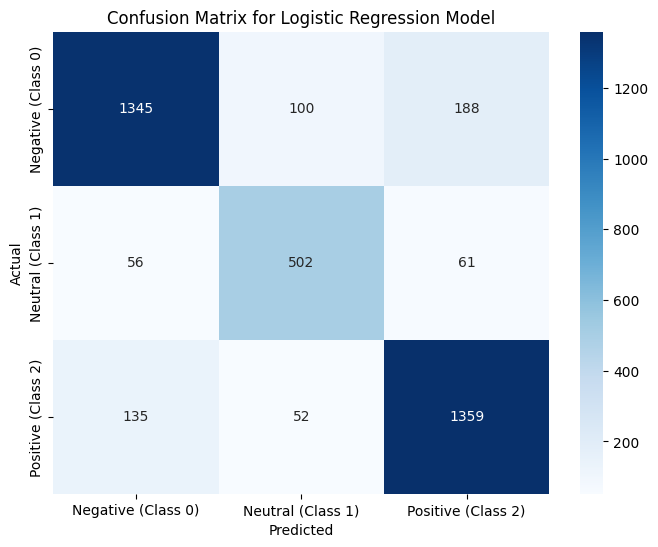

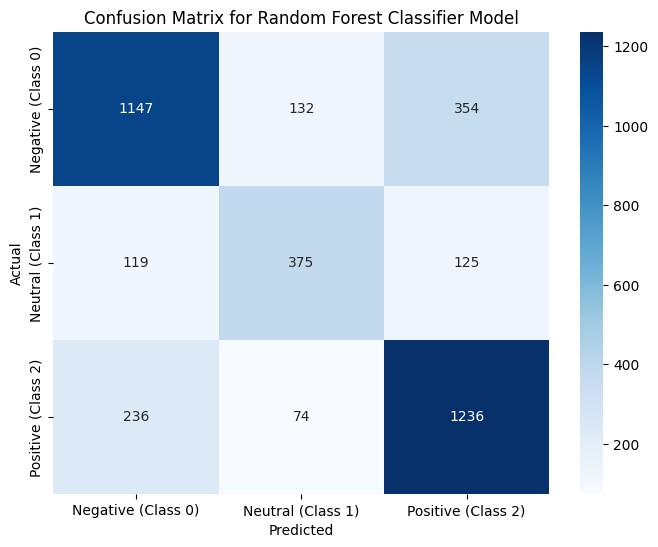

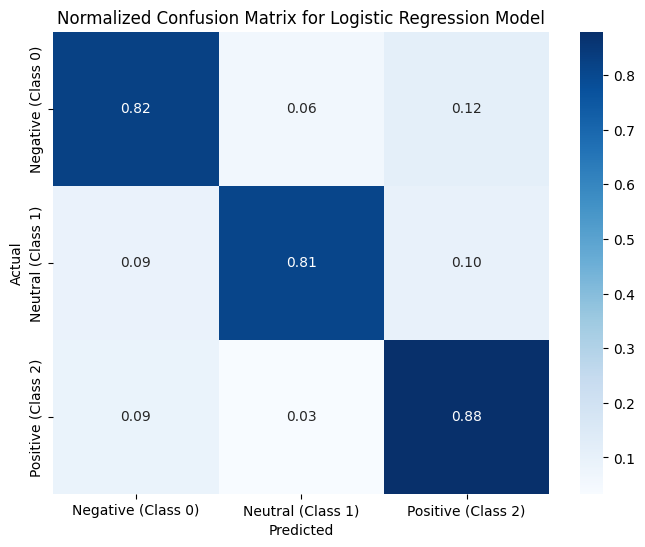

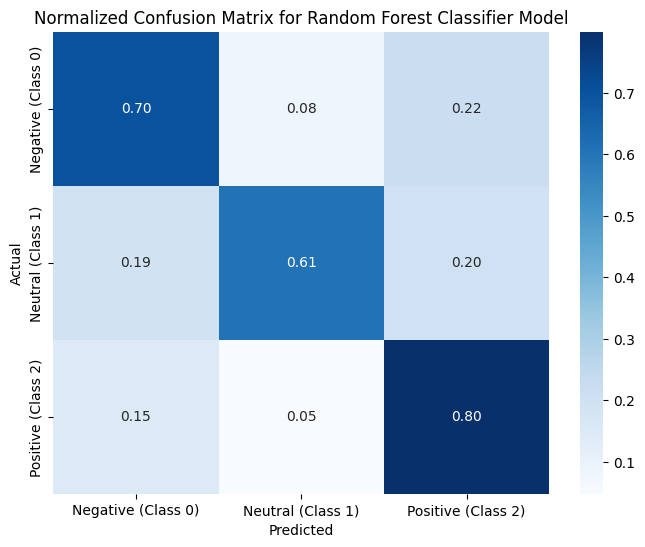

In [100]:
# Number of classes
M = len(np.unique(y_test))
print(M)

# Compute confusion matrices for both classifiers
confusion_mat_lr = create_confusion_matrix(y_test, y_pred_lr, M)
confusion_mat_rf = create_confusion_matrix(y_test, y_pred_rf, M)

# Map the encoded labels back to the sentiment for easier analysis
map_labels_to_sentiment = {
    0: 'Negative (Class 0)',
    1: 'Neutral (Class 1)',
    2: 'Positive (Class 2)',
}

# Plot the confusion matrix for both classifiers
classes = [map_labels_to_sentiment[i] for i in range(M)]
plot_confusion_matrix(confusion_mat_lr, classes, "Confusion Matrix for Logistic Regression Model", normalized=False)
plot_confusion_matrix(confusion_mat_rf, classes, "Confusion Matrix for Random Forest Classifier Model", normalized=False)

# Plot the normalized confusion matrices for both classifiers
normalized_confusion_mat_lr = normalize_confusion_matrix(confusion_mat_lr)
normalized_confusion_mat_rf = normalize_confusion_matrix(confusion_mat_rf)
plot_confusion_matrix(normalized_confusion_mat_lr, classes, "Normalized Confusion Matrix for Logistic Regression Model", normalized=True)
plot_confusion_matrix(normalized_confusion_mat_rf, classes, "Normalized Confusion Matrix for Random Forest Classifier Model", normalized=True)

The focus is on the normalized confusion matrices, as they provide the normalized rates of misclassifications to allow for better comparisons. The Logistic Regression Model seems to have better (larger) rates of correct classification for all three classes (positive, neutral, negative), as well as better (lower) rates of misclassifications for all combinations of classes, compared to the Random Forest Classifier. Both classifiers seem to have the best performance on correctly identifying (true positives) positive sentiment tweets. As expected, the true positive rates for neutral sentiment Tweets are lowest for both models, suggested by the large class imbalance between the neutral sentiment labels and the positive/negative sentiment labels, where there are just far fewer neutral sentiment Tweets in the data, not to mention that, as discovered in EDA, neutral Tweets have less words and are probably more difficult to classify into a positive or negative sentiment.

Moreover, the largest class confusion for both models seems to be predicting true negative sentiment Tweets as being positive, which is reasonable as during EDA, it was found that a lot of the negative sentiment tweets (labeled as negative) contained a lot of positive words, which might skew the prediction based on the relationships between features that is formulated.

This has implications for both models; a low detection rate of negative sentiments, where true negative sentiment Tweets are being predicted to be positive sentiment, implies that a lot of harmful Tweets using negative words and terminology are filtered and displayed as positive, which might influence public opinion and satisfaction.

Thus, the Random Forest Classifier struggles more with distinguishing between neighboring sentiment classes. In fact, for class 0 (negative sentiment), Logistic Regression significantly outperforms the Random Forest Classifier, with fewer false negatives/positives. For class 1 (neutral sentiment), both models seem to struggle a bit more, but Logistic Regression still makes less mistakes, especially considering false negatives. For class 2 (positive sentiment), Logistic Regression also performs better with fewer false negatives and false positives than the Random Forest Classifier.

Logistic regression is thus better at distinguishing the three classes most likely due to the data sparsity, as the linear decision boundary is suited for this high-dimensional data. It also has fewer errors for the neutral class, where the Random Forest Classifier seems to struggle far more with than the other two classes. In fact, the Random Forest Classifier has more misclassification rates especially for the negative and positive sentiments and seems to struggle with the highly sparse data set (noise in decision making).

Next, the metrics (precision, recall, and F1 score) as well as support (the number of occurences of the classes) are observed and compared across the classes between the two models.

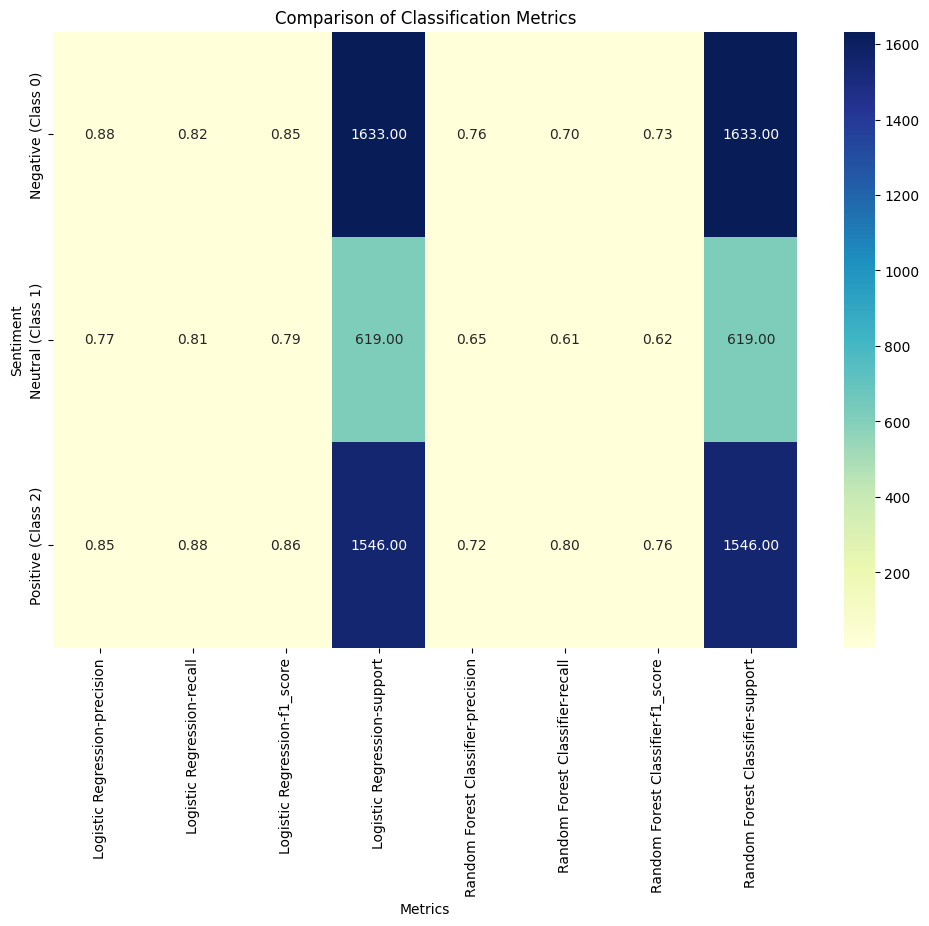

In [89]:
# Compute metrics for both classifiers
metrics_lr = compute_metrics_from_confusion_matrix(confusion_mat_lr)
metrics_rf = compute_metrics_from_confusion_matrix(confusion_mat_rf)

# Plot the comparisons of metrics of the classifiers
plot_classification_metrics(metrics_lr, metrics_rf, ["Logistic Regression", "Random Forest Classifier"], classes, "Comparison of Classification Metrics")

As shown above, the Logistic Regression model significantly outperforms the Random Forest Classifier across all metrics. The Logistic Regression model does better on precision (0.88 vs 0.76), recall (0.82 vs 0.70), and F1 score (0.85 vs 0.73) compared to the Random Forest Classifier for Class 0 (negative sentiment). The Logistic Regression model also does slightly better on precision (0.77 vs 0.65), recall (0.81 vs 0.61), and F1 score (0.79 vs 0.62) compared to the Random Forest Classifier for Class 1 (neutral sentiment), although the Random Forest Classifier seems to demonstrate some more improvement and balance between precision and recall for the neutral class. The Logistic Regression model also does better on precision (0.85 vs 0.72), recall (0.88 vs 0.80), and F1 score (0.86 vs 0.76) compared to the Random Forest Classifier for Class 0 (negative sentiment). Particularly for the Neutral class, which seems to be the most difficult for both models to classify correctly, the Logistic Regression model is superior.

The average (macro and weighted) versions of the metrics (averaged across all three classes) between the two models are also compared, as demonstrated below.

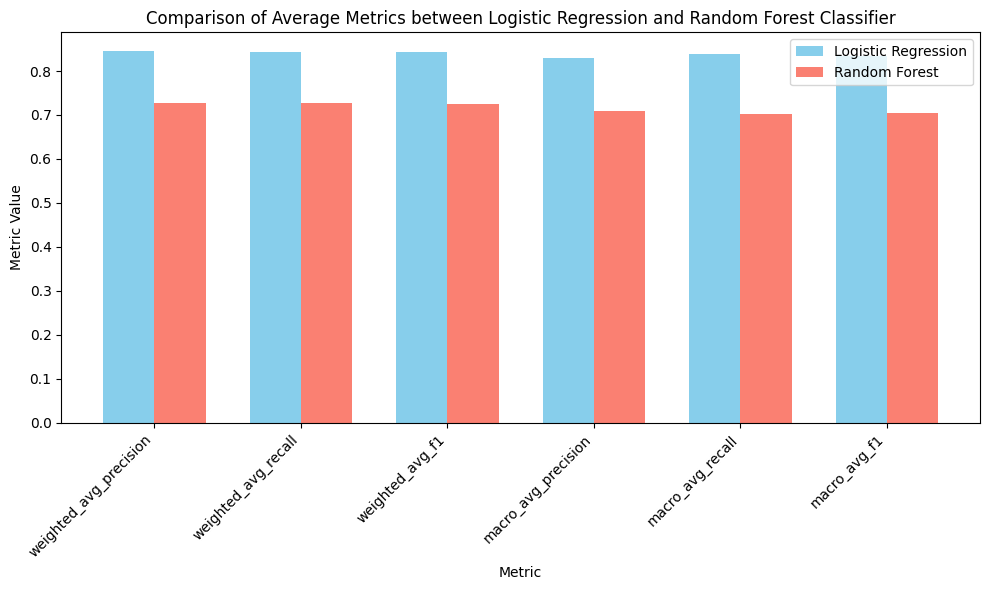

In [88]:
# Compute the macro and weighted averages of the metrics for both classifiers
avg_metrics_lr = compute_macro_and_weighted_averages_of_metrics(metrics_lr)
avg_metrics_rf = compute_macro_and_weighted_averages_of_metrics(metrics_rf)

# Plot comparisons of the average metrics between the classifiers
plot_avg_metrics(avg_metrics_lr, avg_metrics_rf, "Logistic Regression", "Random Forest")

As shown, the Logistic Regression Model outperforms the Random Forest Classifier across all classes when considering the macro and weighted average metrics of precision, recall, and F1 score. The Logistic Regression Model achieves average metrics of precision, recall, and F1 score of around 83%-85%, wehile the Random Forest Classifier achieves average metrics of precision, recall, and F1 score of around 70%-73%, which is statistically significantly lower.

### Comparing Computational Complexity

Let $n$ denote the number of data samples, $p$ denote the number of features, $T$ denote the number of decision trees (for the Random Forest Classifier), and $d$ denote the depth of the tree (for the Random Forest Classifier).

The Logistic Regression Model has a training time complexity of $O(n*p)$, a test time complexity of $O(p)$, and a space complexity of $O(p)$.

The Random Forest Classifier has a training time complexity of $O(T*n*\log(n)*p)$, a test time complexity of $O(T*p)$, and a space complexity of $O(T*d)$.

Thus, in general, especially for a large amount of decision trees $T$ (recall the 'n_estimators' used in implementing the Random Forest Classifier), the Logistic Regression Model also generally outperforms the Random Forest Classifier in terms of training, test, and space efficiency. In terms of training time, it was already noted previously; to train on the large dataset of more than 40,000 data samples with more than 20,000 features, the Logistic Regression Model surprisingly only took 0.562s to train, while the Random Forest Classifier took 120.478s to train, which is around 214 times the training time (for 'n_estimators' of 100 using 'max_features' of 'sqrt'). This was also seen with test time, as the Logistic Regression Model took only around 0.001s for predicting on the entire test data set, while the Random Forest Classifier took around 0.309s, which is around 309 times the test time.

Observe that even for $T=1$, the training time complexity of the Logistic Regression Model ($O(n*p)$) is better than that of the Random Forest Classifier with one decision tree ($O(n*\log(n)*p)$). Now, as $T$ increases, and as was observed during the tuning of the parameters with cross validation, the Logistic Regression Model outperforms the Random Forest Classifier in training time more and more, even though both depend on the number of data samples and the number of features, both of which are very large for this task.

Therefore, in terms of computational complexity, the Logistic Regression Model generally significantly outperforms the Random Forest Classifier.

### Final Recommendation

Based on the comparisons of computational complexities and performance on the unseen test data between the Logistic Regression Model and Random Forest Classifier, the **Logistic Regression Model** is the method that should go into production for this dataset.

In terms of performance on the test data, the Logistic Regression Model had better precision, recall, and F1 scores across all the classes compared to the Random Forest Classifier. Moreover, in terms of computational complexities, the Logistic Regression Model has significantly faster training and test time compared to the Random Forest Classifier. However, this brings up an interesting point: why is it that Logistic Regression is significantly better on this dataset compared to the Random Forest Classifier, which is expected to be robust with 100 estimator decision trees?

One possible explanation is data sparsity. Recall from before that it was found that after performing TF-IDF vectorization on the training and test data, even after all of the cleaning and pre-processing as an attempt to reduce the dimensionality of the data, the data still has 99.95% sparsity, which is very sparse! This also includes the more than 20,000 features across the more than 40,000 data samples. A logistic regression approach for such high-dimensional sparse data may be more suited because it helps directly model the linear relationships among various features and classes, and the regularization (e.g., set by the 'C' parameter from before) can help mitigate issues with sparsity by reducing overfitting from potentially noisy and highly sparse data. On the other hand, the Random Forest classifier seems to struggle with higher-dimensional sparse data. This might be because the splitting decisions across individual features lacks enough variance and motivation due to how far apart and sparse the data sample vectors are; additionally, a lot of the splits could involve irrelevant and poorly predictive features, which reduces performance.

Another possible explanation is the size of the feature space in this task. In logistic regression, with appropriate regularization, the model can better generalize on the sparse data as it can use the entire feature space to a larger degree; a random forest approach splits with the random selection of a subset of features (see the discussion on the 'max_features' parameter from before), which could cause diminishing returns in capturing more subtle relationships in such a high dimensional space.

A final explanation is simply the model complexities. Logistic regression is generally a much simpler model and does not have as many tunable parameters, so with proper grid search and cross validation, it can better generalize on the sparse data; the random forest is generally more complex and might have difficulties with splitting features in such a high dimensional space without having a significant number of trees ('n_estimators'), which again would also diminish the model's time to train and test, which would not yield a reasonable tradeoff between accuracy and time efficiency.

Therefore, given the sparse and high-dimensional nature of this dataset, Logistic Regression is more suited for the task. Due to the time constraints of this project, the grid search across the tunable parameters was relatively small; as a future work, the parameters, and especially the 'C' parameter for regularization, can be further tuned to help balance regularization further. Moreover, more thought can be put into feature selection to further reduce the dimensionality of the data, such as using Principal Component Analysis (PCA). If a Random Forest Classifier is still desired, however, a possible consideration is also increasing the grid search and focusing on a larger value for 'n_estimators' for more trees to capture all the patterns in the sparse high-dimensional data; however, this would drastically impact training and test speed, so that needs to be taken into account; nonetheless, reducing dimensionality would also help make the random feature splits in the Random Forest Classifier more impactful and relevant.

Besides the decent performance of the Logistic Regression Model on the test data, alternative models can still be explored. For instance, a Support Vector Machine (SVM) with a linear kernel could work well with the sparse data. A Naive Bayes classifier also could be effective for text data by assuming independence between the vast feature space depending on the sentiment classes. Another noticeable model brought into discussion during independent research was Gradient Boosting, such as XGBoost, which might perform even better than the Random Forest Classifier due to the highly sparse and high-dimensional data.

# Discussion on Ethical Issues for the Dataset/Task

This section provides a discussion on the ethical aspects of the machine learning task carried out on this dataset.

### Sources of Bias in Sentiment Analysis

Bias introduced in sentiment analysis can arise from training data, pre-processing, and design of the models. Training data bias can occur when the dataset lacks diversity or can overrepresent a specific group, which means the model don't generalize well. Pre-processing techniques such as cleaning text and removing stop words and lemmatization can also inadvertently affect the language groupings or variation with bias. The model bias can come from when the feature space is large and the model assigns more weight to more overrepresented features, which can fail to address fairness and reinforces societal stereotypes.

The consequences of data bias in sentiment analysis include a distortion of the analysis, unfair decision-making, reinforcement of societal stereotypes, exclusion of underrepresented groups, and losing user trust. For instance, based on how the Tweets were collected, there could be political or gender or even language bias.

Mitigation of this may include getting more diverse training data, augmenting the training data to allow for representing underrepresented groups, using models that assign more fair weights to various features in the feature space is large, performing audits and evaluating bias frequently, and ensuring the models are updated to reflect changes in society, which affects the data. To avoid discrimination, protect individual rights, maintain user trust, and make an inclusive ecosystem, data bias has to be avoided in sentiment analysis.

### Privacy Concerns in Sentiment Analysis
Performing sentiment analysis on social media platforms can also raise huge flags in privacy concerns. Collecting data may require analyzing content from users, sometimes without their understanding. This can also create risks in accidentally identifying users through the content (such as their Tweets), which can link them to certain sentiments and result in profiling. Some models, especially if using N-grams, might also use context information, as well as other features as location and account name (see the EDA section), which might cause privacy violations. Moreover, third-party access to the data has some risks, as well as improperly storing the data resulting in breaches.

Sentiment analysis can also be misused to invade someone's privacy, discriminate against them, remove free will/expression, create false positive flags on what content they put out, and can create algorithmic biases, which reinforce inequalities and lead to sentiments being misinterpreted.

Mitigation may involve being more transparent about how the data is used, gaining consent, and anonymizing the data. Moreover, there should be frequent audits and security measures to adhere to legal regulation and best data storage practices.

### Consent and Data Collection in Sentiment Analysis
It is critical to obtain consent for collecting data and using sentiment analysis, especially when it comes to respecting privacy, autonomy, and any other motivations. The persons of interest should be able to decide how their information is used. Consent allows for informed decision-making where one can understand what the sentiment analysis of their data implies, while maintaining autonomy and their respective personal rights. This also allows for enhanced user satisfaction and trust in the system, which is critical for keeping the sentiment analysis system running, not to mention compliance with legal standards. This also helps with the ethics of it, by mitigating any risks of bias and discrimination across different groups of people.

Nonetheless, data collection from public sources may still be challenging considering it is still important to gain consent for such content while respect others' expectations about how their data is used, not to mention the contextual privacy concerns. Another introduced challenge is being overly dependent on public data, as there could be more inaccuracies introduced, as well as misuse of the sentiment analysis system; thus, ethical frameworks need to be put in place to promote transparency, fairness, and responsible adaptation of the models. The handling of the data ethically is also associated with further risks when it comes to using secondary data.

To mitigate such challenges when collecting and analyzing possibly personal content data, the privacy violations and misuse of personal informed consent must be addressed. Transparency promotes trust, and accurate data collection helps avoid reinforcing societal bias and discrimination. Moreover, data security can be a large concern when exposing sensitive information, so data standards should be put into place. Also, underrepresented populations may require further protections and consent analyss, to prioritize their interests as well. Communication and transparency about the system has to be clear, with properly obtained consent, and enforced with rigorous ethical compliance standards.

### Main Ethical Considerations in Sentiment Analysis

**Respecting Privacy**: privacy is important as it must be ensured that the data from individuals is secured and properly handled, anonymized, etc. with their consent.

**Removing Bias and Ensuring Fairness**: it is important to identify key biases in the algorithms used by the models to prevent unfair evaluation of content based on its origins (e.g., a group of people)

**Remaining Transparent**: there needs to be transparency behind how the data is used in the models, to allow for more trust from the user base.

**Maintaining Accuracy**: the models should frequently be refined to reduce errors in the decision making process of predicting sentiment, including possible and periodic human review, especially for more complex situations.

**Understanding the Context**: cultural and linguistic variations need to be accounted for to improve the interpretation of what sentiment truly is.

**Fostering Responsible Use**: one would need to evaluate the impact of using sentiment analysis on the general population to ensure outcomes remain equitable across all groups.

**Following Standard Ethical Guidelines**: a lot of different legal regulations need to be followed for responsible use.

**Encouraging Human Involvement in the Process**: human oversight is critical for maintaining pipelines with the machine learning models, to ensure extreme cases such as sarcasm and ambiguous texts are handled properly (which was observed with some of the Tweets during EDA in this project).

**Empowering the Users of the System**: the user data is at the core of the data used to drive the sentiment analysis models; each individual should have full control over how their data is used, and should be able to challenge any analysis of the sentiment analysis results.

**Continually Improving Ethical Guidelines**: the models should be frequently reviewed and audited to ensure any risks are addressed and that mainstream ethical guidelines are being closely followed.

### Mitigating the Ethical Considerations in Sentiment Analysis

**Promoting Equality for All**: by consistently promoting equality, it is ensured that there is less bias in the system such that all users regardless of background are analyzed equivalently.

**Building Trust in How the Data is Used**: user privacy needs to be protected to increase the user trust and confidence in the sentiment analysis models.

**Being Clear**: practicing transparency is important to ensure the users understand the decision making from the model outputs and how the data is handled.

**Preventing Misuse**: risks such as misuse of the sentiment analysis to harm reputations must be mitigated with the proper approaches.

**Understanding the Societal Impact**: fairness and inclusivity need to be valued and prioritized above all else; sentiment analysis should be a positive impact on all groups in the population, and not just a subset.

**Innovation and Learning**: considering the ethical pitfalls of these sentiment analysis models helps ensure the models are refined; the developers are to be held accountable and must take full responsibility in the societal impacts of these sentiment analysis models.

# Bibliography

1. **Coronavirus tweets NLP - Text Classification**  
   Source: Kaggle
   URL: [https://www.kaggle.com/datasets/datatattle/covid-19-nlp-text-classification](https://www.kaggle.com/datasets/datatattle/covid-19-nlp-text-classification)  

2. **March 11, 2020: The Day Everything Changed**  
   Source: NPR
   URL: [https://www.npr.org/2021/03/11/975663437/march-11-2020-the-day-everything-changed](https://www.npr.org/2021/03/11/975663437/march-11-2020-the-day-everything-changed)  

3. **scikit-learn GridSearchCV Documentation**
   Source: scikit-learn
   URL: [https://scikit-learn.org/dev/modules/generated/sklearn.model_selection.GridSearchCV.html](https://scikit-learn.org/dev/modules/generated/sklearn.model_selection.GridSearchCV.html)

4. **scikit-learn LogisticRegression Documentation**
   Source: scikit-learn
   URL: [https://scikit-learn.org/1.5/modules/generated/sklearn.linear_model.LogisticRegression.html](https://scikit-learn.org/1.5/modules/generated/sklearn.linear_model.LogisticRegression.html)

5. **scikit-learn RandomForestClassifier Documentation**
   Source: scikit-learn
   URL: [https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html)

6. **scikit-learn TfidfVectorizer Documentation**
   Source: scikit-learn
   URL: [https://scikit-learn.org/1.5/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html](https://scikit-learn.org/1.5/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html)

7. **What are stemming and lemmatization?**  
   Source: IBM
   URL: [https://www.ibm.com/think/topics/stemming-lemmatization](https://www.ibm.com/think/topics/stemming-lemmatization) 

8. **What is stemming?**
   Source: IBM
   URL: [https://www.ibm.com/think/topics/stemming#:~:text=First%2C%20while%20the%20Lovins%20and,%2C%20French%2C%20and%20even%20Russian.)](https://www.ibm.com/think/topics/stemming#:~:text=First%2C%20while%20the%20Lovins%20and,%2C%20French%2C%20and%20even%20Russian.)

9. **What is Tokenization?**
   Source: datacamp
   URL: [https://www.datacamp.com/blog/what-is-tokenization](https://www.datacamp.com/blog/what-is-tokenization)